# set up environment

In [1]:
# run on hssm_test
# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import numpy as np
import pandas as pd
import pathlib
import seaborn
from pathlib import Path 
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrix
from ssms.basic_simulators.simulator import simulator
import bambi as bmb
from pandas.api.types import CategoricalDtype
import ssms
import pytensor  # Graph-based tensor library
import hssm
import random
import math
# Set float type to float32 to avoid a current bug in PyMC 
# This will not be necessary in the future
hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


# set up paths

In [2]:
basepath = '/users/afengler/data/proj_tt/mpib-HSSM-oddball-data'

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/models/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/results/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/plots/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/ppc/hssm/').mkdir(parents=True, exist_ok=True)

# set up data

## response as accuracy

In [3]:
df = pd.read_csv(basepath+'/data/OB_singletrial_YAOA.csv')

df['response'] = df['accuracy']
# And then modify the 'response' column where the condition is met
df.loc[df['response'] == 0, 'response'] = -1

df.rename(columns={'reactiontime': 'rt'}, inplace=True)
df.rename(columns={'id': 'participant_id'}, inplace=True)

oddballDataDay2 = df[df['response'].notna()]

data=oddballDataDay2[:]
dataForModel = data[data['pupil'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['beta_insula'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['switch_condition_num'].notna()]


dataForModel['switch_condition_num']=isinstance(dataForModel['switch_condition_num'].dtype, CategoricalDtype)

## response as choices

In [4]:
df2 = pd.read_csv(basepath+'/data/OB_singletrial_YAOA.csv')
df2['switch_condition_num']

#dataForModel["trl_condition_bin"] (1==standard, 2==oddball)
#dataForModel["trl_condition"] (1==standard, 2==oddball1,3==oddball2)
choice1=pd.Series([np.nan]*len(df2["trl_condition"]))
for i in range(len(df2["trl_condition"])): 
    if df2["accuracy"].iloc[i] == 1:
        choice1[i]=int(df2["trl_condition"].iloc[i]-1)
    elif df2["accuracy"].iloc[i] == 0 and df2["trl_condition_bin"].iloc[i] == 2:   
        choice1[i]=0
    elif df2["accuracy"].iloc[i] == 0 and df2["trl_condition_bin"].iloc[i] == 1: 
        choice1[i]=random.randint(1, 2)
    
df2['response']=choice1    
df2.rename(columns={'reactiontime': 'rt'}, inplace=True)
df2.rename(columns={'id': 'participant_id'}, inplace=True)

In [5]:
df2

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       0.0  
1                       1.0        -0.174549        -0.033526       0.0  
2                       3.0         0.289645         1.666682       2.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       0.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       0.0  
11285                   1.0        -0.197492        -0.575755       0.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       0.0  
11288                   1.0        -0.133665        -0.081732       0.0  

[11289 rows x 23 columns]

In [6]:
oddballDataDay2Choice = df2[df2['response'].notna()]

In [7]:
oddballDataDay2Choice

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       0.0  
1                       1.0        -0.174549        -0.033526       0.0  
2                       3.0         0.289645         1.666682       2.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       0.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       0.0  
11285                   1.0        -0.197492        -0.575755       0.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       0.0  
11288                   1.0        -0.133665        -0.081732       0.0  

[11227 rows x 23 columns]

In [8]:
oddballDataDay2Choice['response'].unique()

array([0., 2., 1.])

In [9]:
oddballDataDay2Choice = oddballDataDay2Choice.copy()
oddballDataDay2Choice = oddballDataDay2Choice[oddballDataDay2Choice['switch_condition_num'].notna()]

oddballDataDay2Choice = oddballDataDay2Choice.reset_index(drop=True)

In [10]:
oddballDataDay2Choice

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   52293   54793   -1250   
1                  1           42013       1   54293   56793   -1250   
2                  1           42013       1   57293   59793   -1250   
3                  1           42013       1   59293   61793   -1250   
4                  1           42013       1   61293   63793   -1250   
...              ...             ...     ...     ...     ...     ...   
11159             77           62433       2  463649  466149   -1250   
11160             77           62433       2  465649  468149   -1250   
11161             77           62433       2  470649  473149   -1250   
11162             77           62433       2  472649  475149   -1250   
11163             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   2     74       16        1  ...    -0.065556 -0.771706   
1                   3     78       16        1  ...     0.509185 -0.017799   
2                   4     82       16        1  ...     1.049503 -0.247686   
3                   5     86       16        1  ...    -0.611262  0.441441   
4                   6     90       16        1  ...    -0.546911  1.490605   
...               ...    ...      ...      ...  ...          ...       ...   
11159             155    657       16        1  ...    -0.901538 -1.274403   
11160             156    661       16        1  ...     0.026958 -0.852999   
11161             157    665       16        1  ...    -0.940993  1.145411   
11162             158    669       16        1  ...    -0.779456  1.448574   
11163             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0     -0.275299  0.985568                  1       stay_standard   
1      1.874566  0.985568                  2   switch_to_oddball   
2     -0.516399  0.985568                  2        stay_oddball   
3      0.710667  0.985568                  1  switch_to_standard   
4      0.795430  0.985568                  1       stay_standard   
...         ...       ...                ...                 ...   
11159  0.761824  0.386572                  1       stay_standard   
11160 -0.115871  0.386572                  1       stay_standard   
11161  1.098559  0.386572                  2   switch_to_oddball   
11162 -0.044915  0.386572                  1  switch_to_standard   
11163  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       1.0        -0.174549        -0.033526       0.0  
1                       3.0         0.289645         1.666682       2.0  
2                       2.0         0.296416         1.691481       1.0  
3                       4.0        -0.418396        -0.926666       0.0  
4                       1.0        -0.238042        -0.266080       0.0  
...                     ...              ...              ...       ...  
11159                   1.0        -0.137351        -0.110256       0.0  
11160                   1.0        -0.197492        -0.575755       0.0  
11161                   3.0         0.066526         1.467764       1.0  
11162                   4.0        -0.082262         0.316131       0.0  
11163                   1.0        -0.133665        -0.081732       0.0  

[11164 rows x 23 columns]

## first look at real data RT

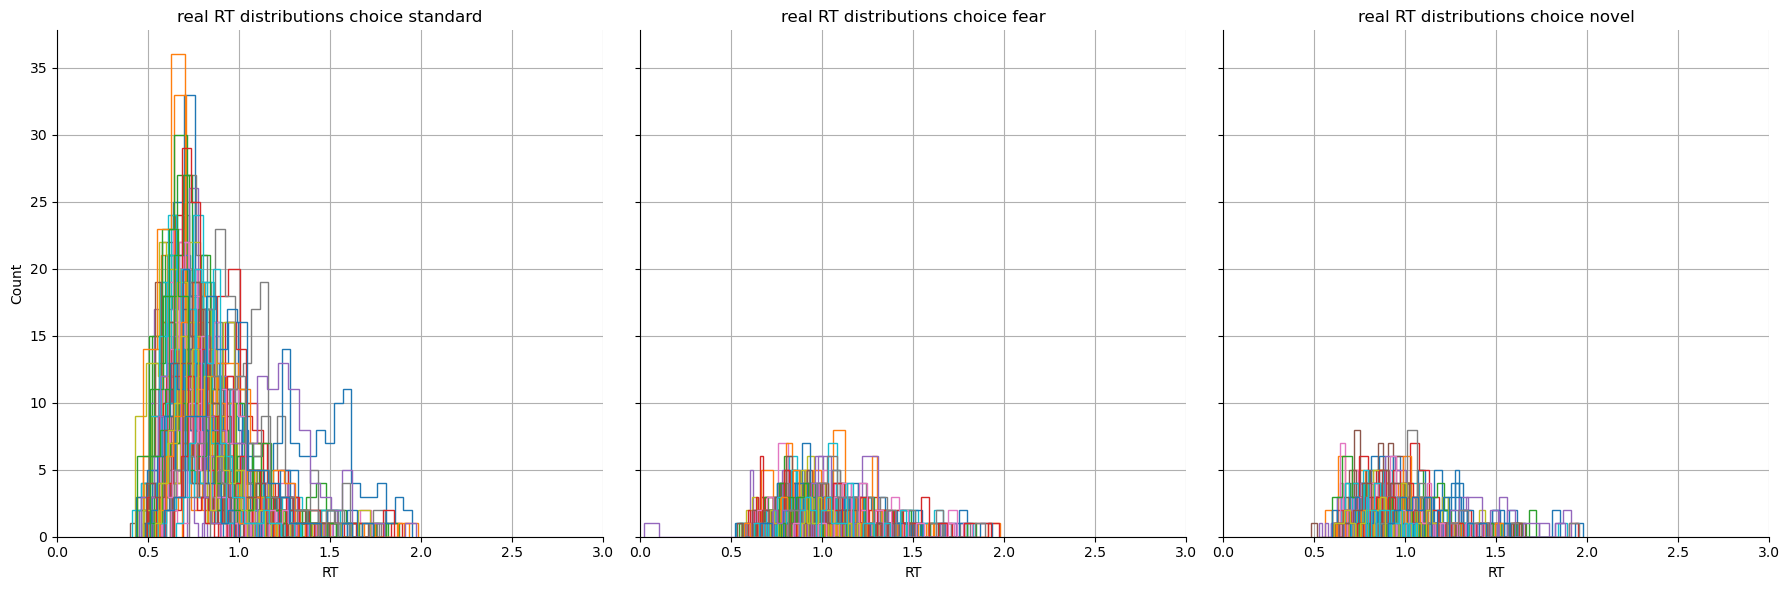

In [12]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']
# Filter data for each response type
dataResponse0 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 0]
dataResponse1 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 1]
dataResponse2 = oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('real RT distributions choice standard')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('real RT distributions choice fear')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('real RT distributions choice novel')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/rea_subRT_dist_all_choices.pdf')


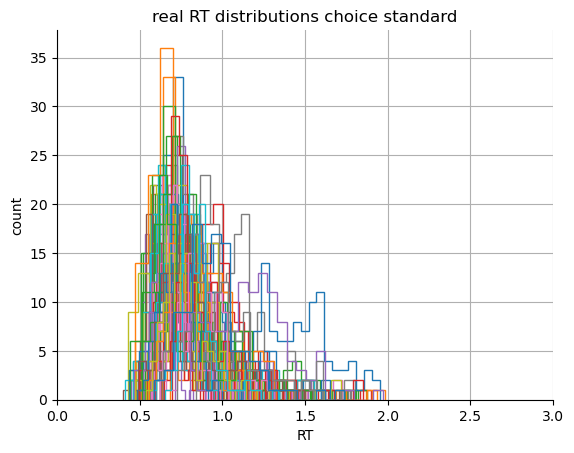

In [28]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']
dataStandardChoice=oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 0]
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions choice standard')
for i, subj_data in dataStandardChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(0,3)   
ax = plt.gca()

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(basepath + '/figures/real_subRT_dist_choice_standard.pdf')

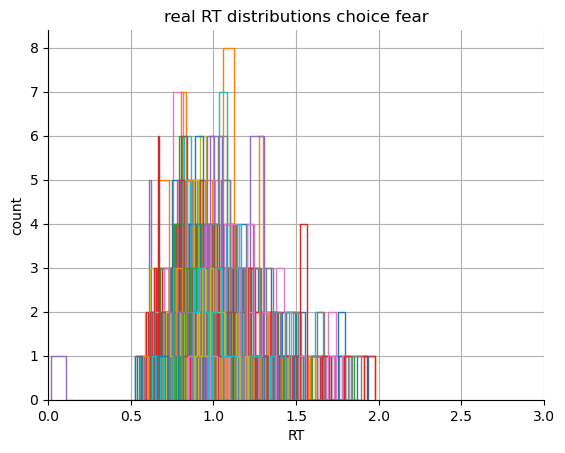

In [31]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']
dataFearChoice=oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 1]
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions choice fear')
for i, subj_data in dataFearChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(0,3) 
ax = plt.gca()

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(basepath + '/figures/real_subRT_dist_choice_fear.pdf')

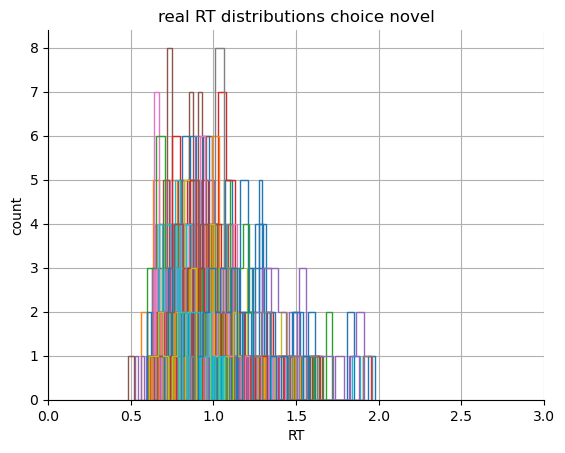

In [30]:
oddballDataDay2Choice['rtPlot']=oddballDataDay2Choice['rt']
dataNovelChoice=oddballDataDay2Choice.loc[oddballDataDay2Choice['response'] == 2]
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions choice novel')
for i, subj_data in dataNovelChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(0,3)   
ax = plt.gca()

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(basepath + '/figures/real_subRT_dist_choice_novel.pdf')

## day2SubList

In [11]:
# based on the real data, we figure:
# we need to simulate data with 'participant_id','rt',and 'response' 
# we need to get the correct sub numbers out and also correct trial number (samples in simulation) per subject
day2SubList=oddballDataDay2Choice['participant_id'].unique()
len(day2SubList)


71

# set up sampler for real data

In [15]:
networkPath=basepath + r"/race_3_no_bias_lan_f2d991a6635b11efb6b1a0423f3e9b4e_torch_model.onnx"
networkPath

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/race_3_no_bias_lan_f2d991a6635b11efb6b1a0423f3e9b4e_torch_model.onnx'

In [16]:
simple_race_model_hier_all_noPrior = hssm.HSSM(
    data=oddballDataDay2Choice,
    model="race_no_bias_3",
    hierarchical=True,
    loglik_kind="approx_differentiable",
    model_config = {
        "list_params": ["v0", "v1", "v2", "a", "z", "t"],
        "bounds": {
            "v0":  (0.0, 2.5),
            "v1": (0.0, 2.5),
            "v2": (0.0, 2.5),
            "a": (1.0, 3.0),
            "z": (0.0, 0.9),
            "t": (0.001, 2),
        },
        "backend": "jax",
    },
    choices=3,
    loglik = networkPath,
    p_outlier = 0,)


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


In [20]:
pathlib.Path(basepath+'/models/race/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_race_model_hier_all_noPrior=simple_race_model_hier_all_noPrior.sample(
    sampler="nuts_numpyro",
    chains=4,
    cores=4,
    draws=3000,
    tune=1000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

fileName = basepath + '/models/race/sept24/numpyro/inferenceData_simple_race_model_hier_all_noPrior.nc'
data = inferenceData_simple_race_model_hier_all_noPrior
az.to_netcdf(data, fileName)


Using default initvals. 

The model has already been sampled. Overwriting the previous inference object. Any previous reference to the inference object will still point to the old object.


/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/race/sept24/numpyro/inferenceData_simple_race_model_hier_all_noPrior.nc'

In [57]:
fileName = basepath + '/models/race/sept24/numpyro/inferenceData_simple_race_model_hier_all_noPrior.nc'
Race3noBias_inferenceData=az.from_netcdf(fileName)

In [58]:
Race3noBias_inferenceData

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [59]:
# first check the summary stats of each model's params from inference on real data
az.summary(Race3noBias_inferenceData,var_names=['v0_Intercept',
                                                'v1_Intercept',
                                                'v2_Intercept',
                                                'a_Intercept',
                                                'z_Intercept',
                                                't_Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v0_Intercept  2.446  0.013   2.422    2.462      0.006    0.005       5.0   
v1_Intercept  0.726  0.091   0.595    0.863      0.043    0.033       5.0   
v2_Intercept  0.741  0.077   0.625    0.902      0.036    0.027       5.0   
a_Intercept   1.382  0.047   1.307    1.442      0.023    0.017       5.0   
z_Intercept   0.053  0.003   0.048    0.057      0.001    0.001       6.0   
t_Intercept   0.314  0.026   0.281    0.356      0.012    0.009       5.0   

              ess_tail  r_hat  
v0_Intercept      13.0   2.54  
v1_Intercept      26.0   2.15  
v2_Intercept      11.0   2.25  
a_Intercept       21.0   2.30  
z_Intercept       11.0   1.86  
t_Intercept       11.0   2.40

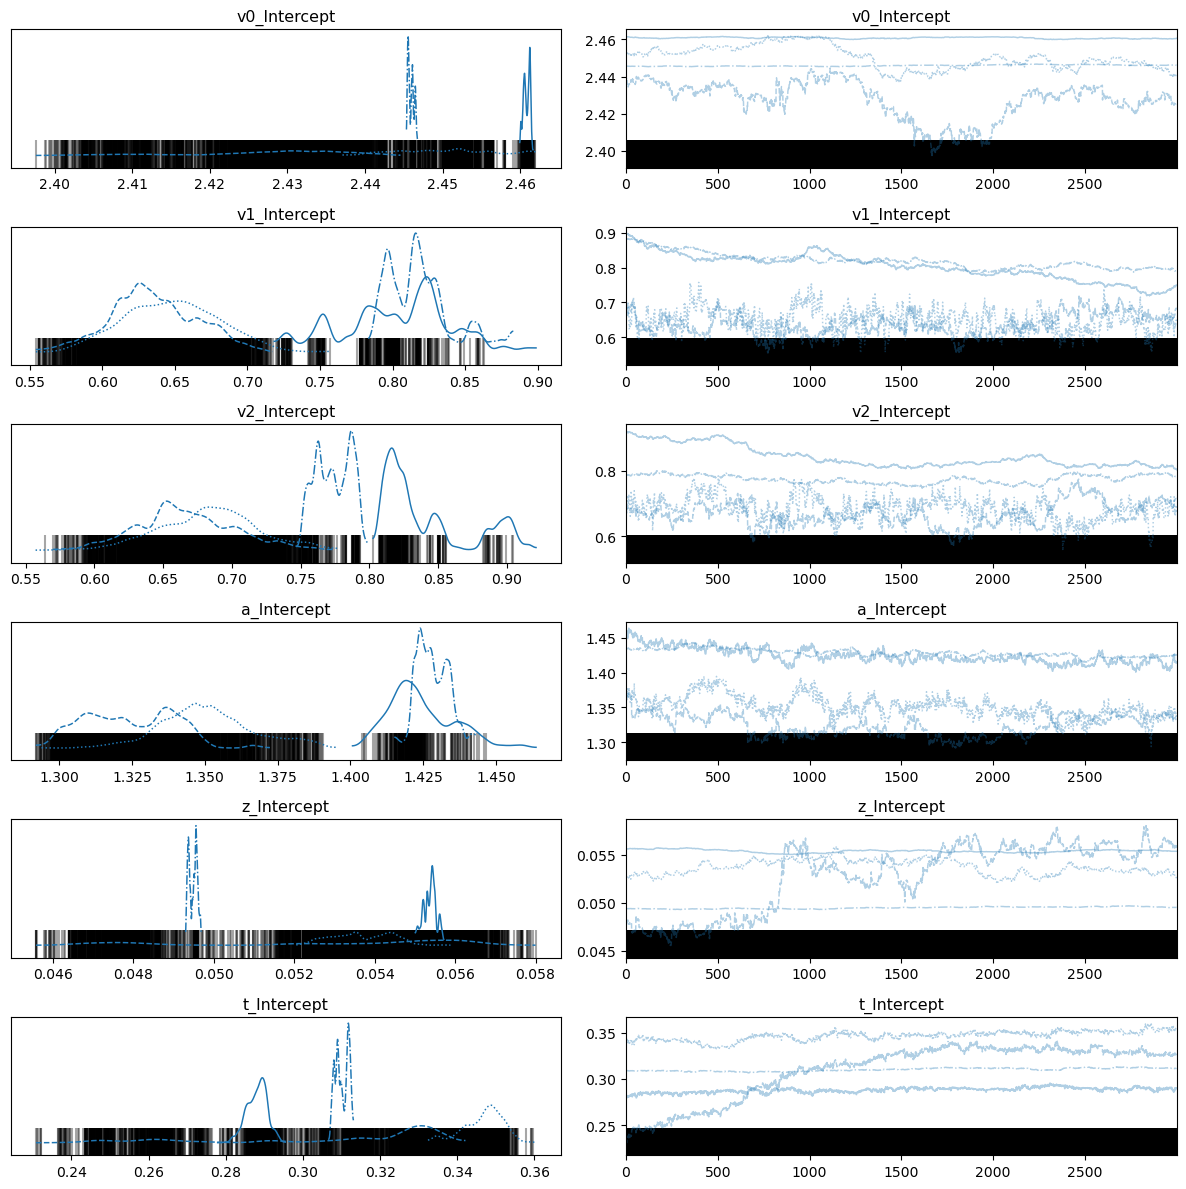

In [60]:
az.plot_trace(
    Race3noBias_inferenceData,var_names=['v0_Intercept',
                                         'v1_Intercept',
                                         'v2_Intercept',
                                         'a_Intercept',
                                         'z_Intercept',
                                         't_Intercept'])
plt.tight_layout()

array([[<Axes: ylabel='v1_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='v2_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='v0_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='v1_Intercept'>, <Axes: xlabel='v2_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

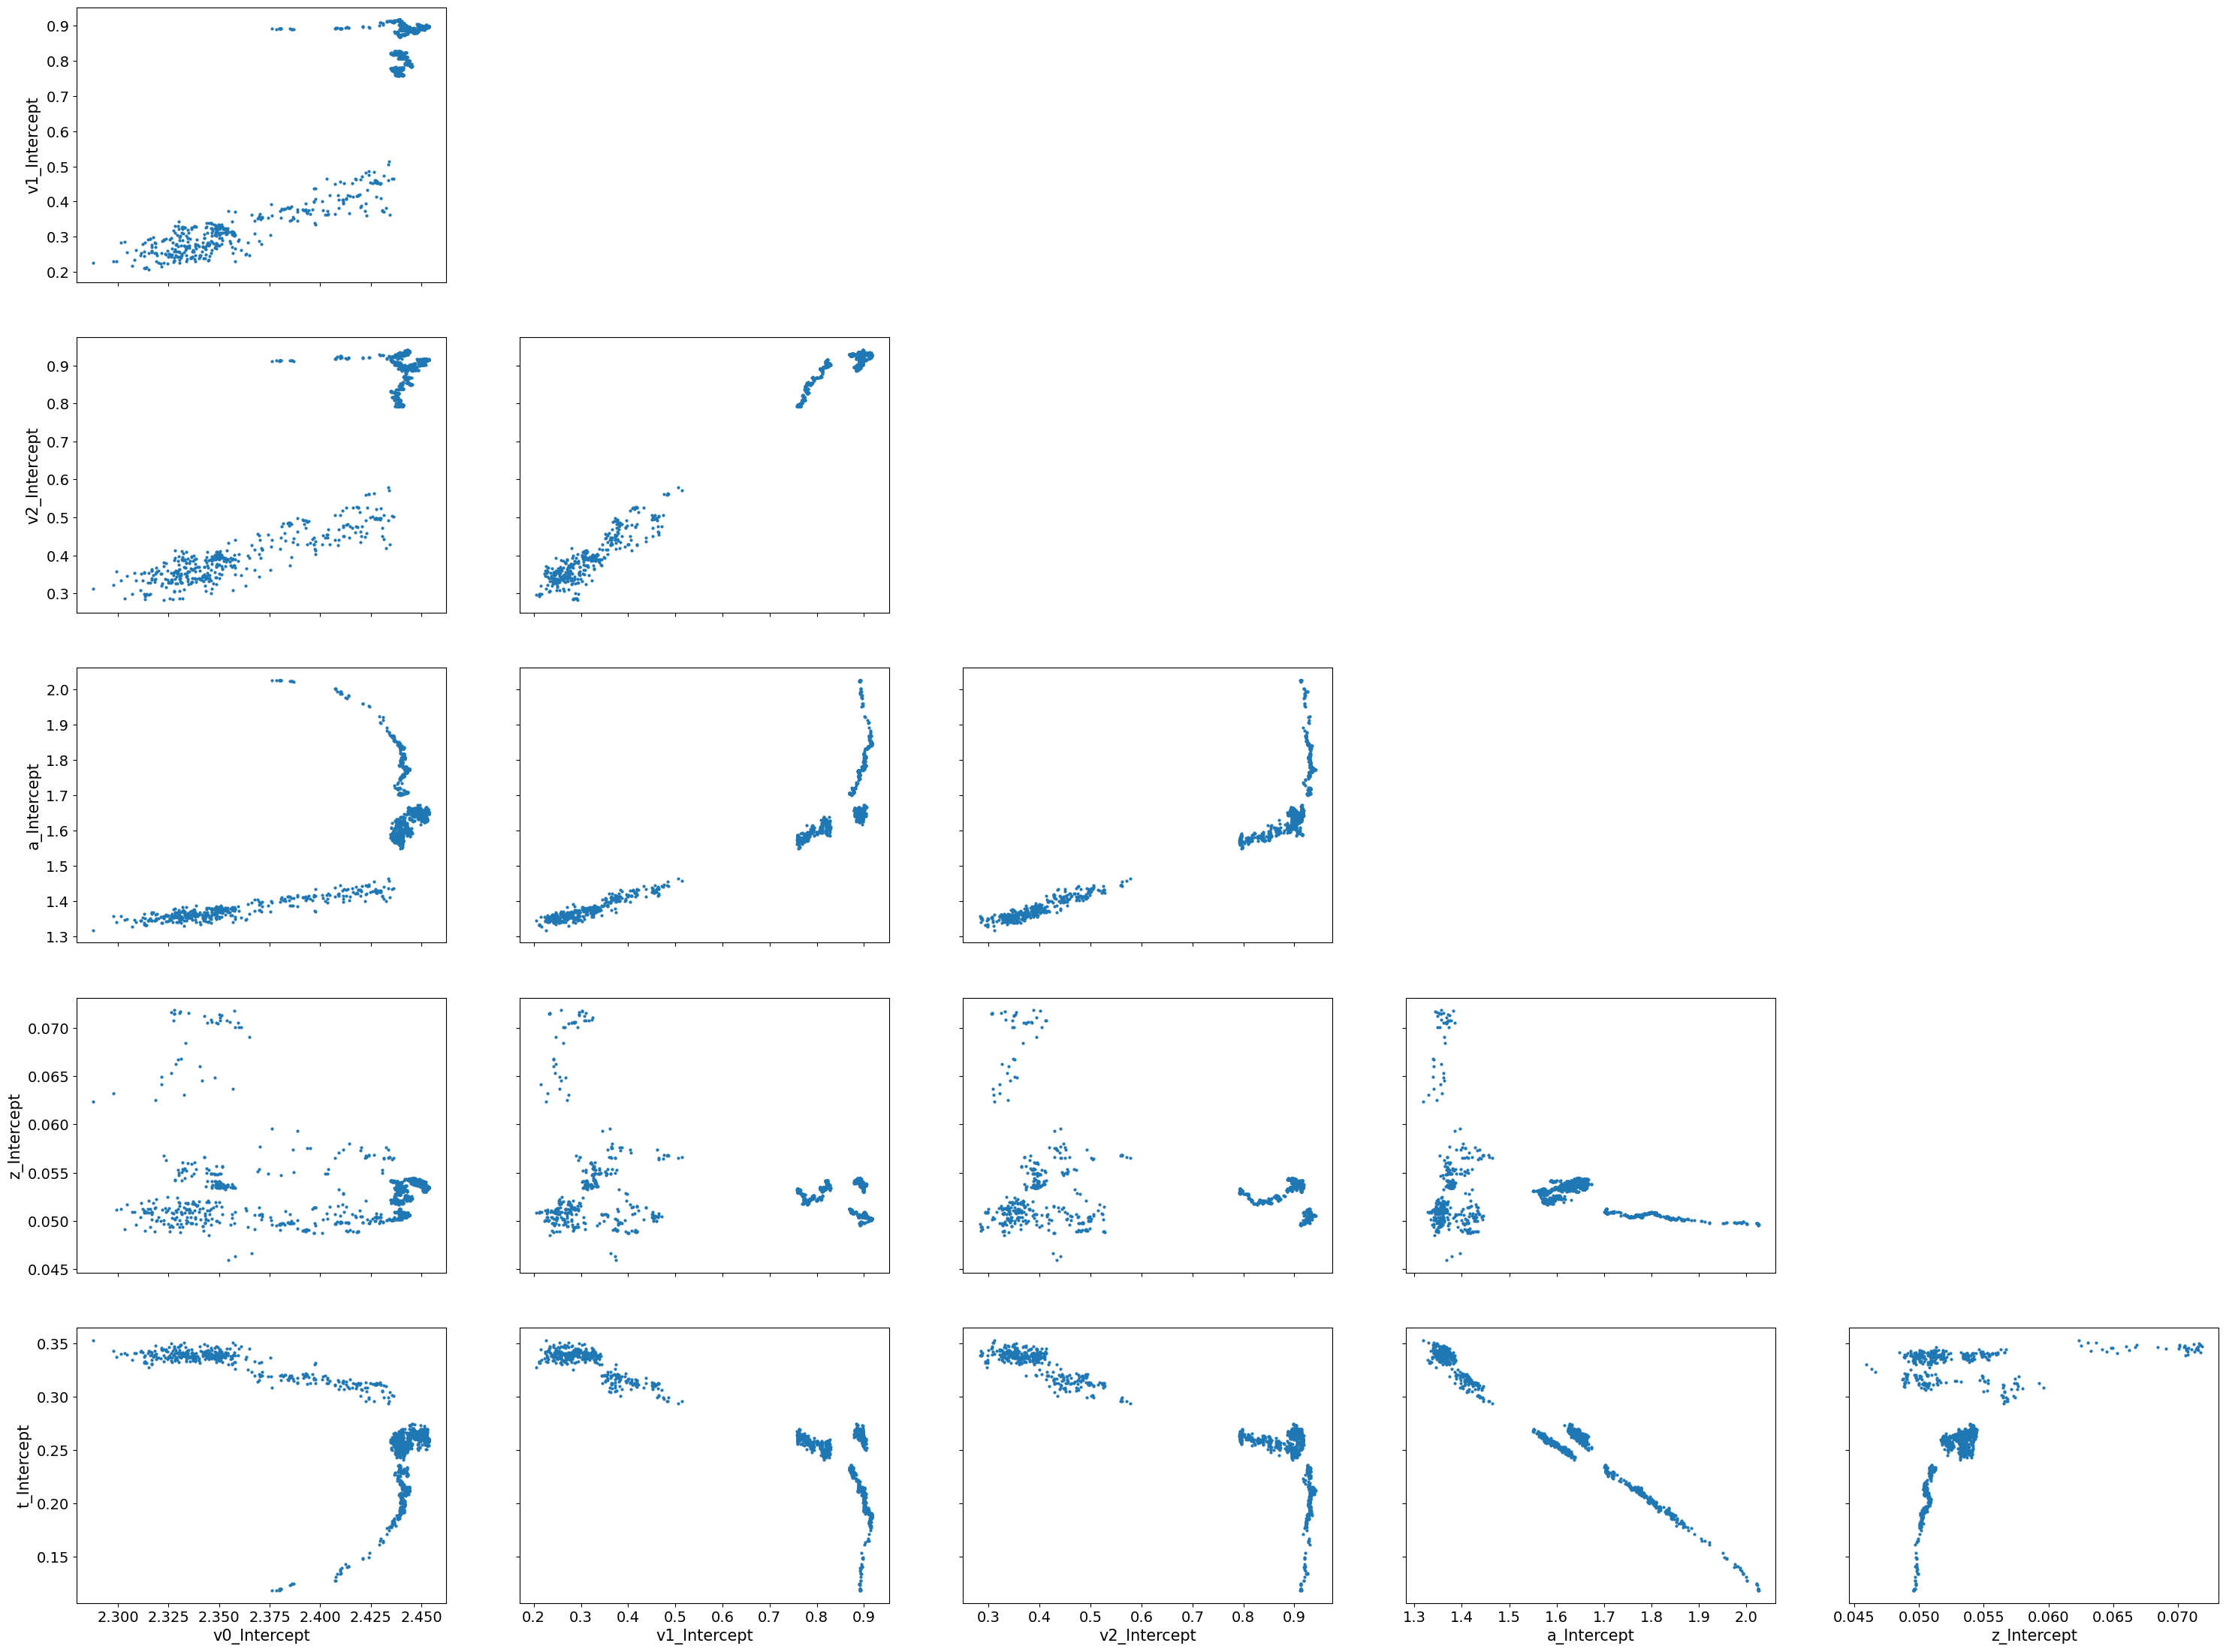

In [61]:
az.plot_pair(
    inferenceData_simple_race_model_hier_all_noPrior,var_names=['v0_Intercept',
                                         'v1_Intercept',
                                         'v2_Intercept',
                                         'a_Intercept',
                                         'z_Intercept',
                                         't_Intercept'])


# simulate data: simplest race 3 choices all params free

In [30]:
ssms.config.model_config['race_no_bias_3']

{'name': 'race_no_bias_3',
 'params': ['v0', 'v1', 'v2', 'a', 'z', 't'],
 'param_bounds': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [2.5, 2.5, 2.5, 3.0, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'n_params': 6,
 'default_params': [0.0, 0.0, 0.0, 2.0, 0.5, 0.001],
 'nchoices': 3,
 'simulator': <cyfunction race_model at 0x7f8534225f20>}

In [12]:
vanillaRACE3allFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    v0_true, v1_true, v2_true, a_true, z_true, t_true = [np.random.normal(2.446,0.013), 
                                                         np.random.normal(0.726,0.091),
                                                         np.random.normal(0.741,0.077),
                                                         np.random.normal(1.382,0.047),
                                                         np.random.normal(0.053,0.003),
                                                         np.random.normal(0.314,0.0026)]

#     v0_true, v1_true, v2_true, a_true, z_true = [1/3, 
#                                                  1/3, 
#                                                  1/3,
#                                                  0.5,
#                                                  0.2]
    # Simulate data
    sim_out = simulator(
        theta=[v0_true, v1_true, v2_true, a_true, z_true, t_true],  # parameter list
        model="race_no_bias_3",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaRACE3allFree_simData=pd.concat([vanillaRACE3allFree_simData, subDataset], ignore_index=True)

In [26]:
vanillaRACE3allFree_simData

participant_id        rt  response
0             42013.0  0.764310       0.0
1             42013.0  0.932953       0.0
2             42013.0  0.790539       0.0
3             42013.0  0.956685       2.0
4             42013.0  0.754593       0.0
...               ...       ...       ...
11159         62433.0  0.552581       0.0
11160         62433.0  0.667757       2.0
11161         62433.0  0.655598       0.0
11162         62433.0  0.704472       0.0
11163         62433.0  0.859126       2.0

[11164 rows x 3 columns]

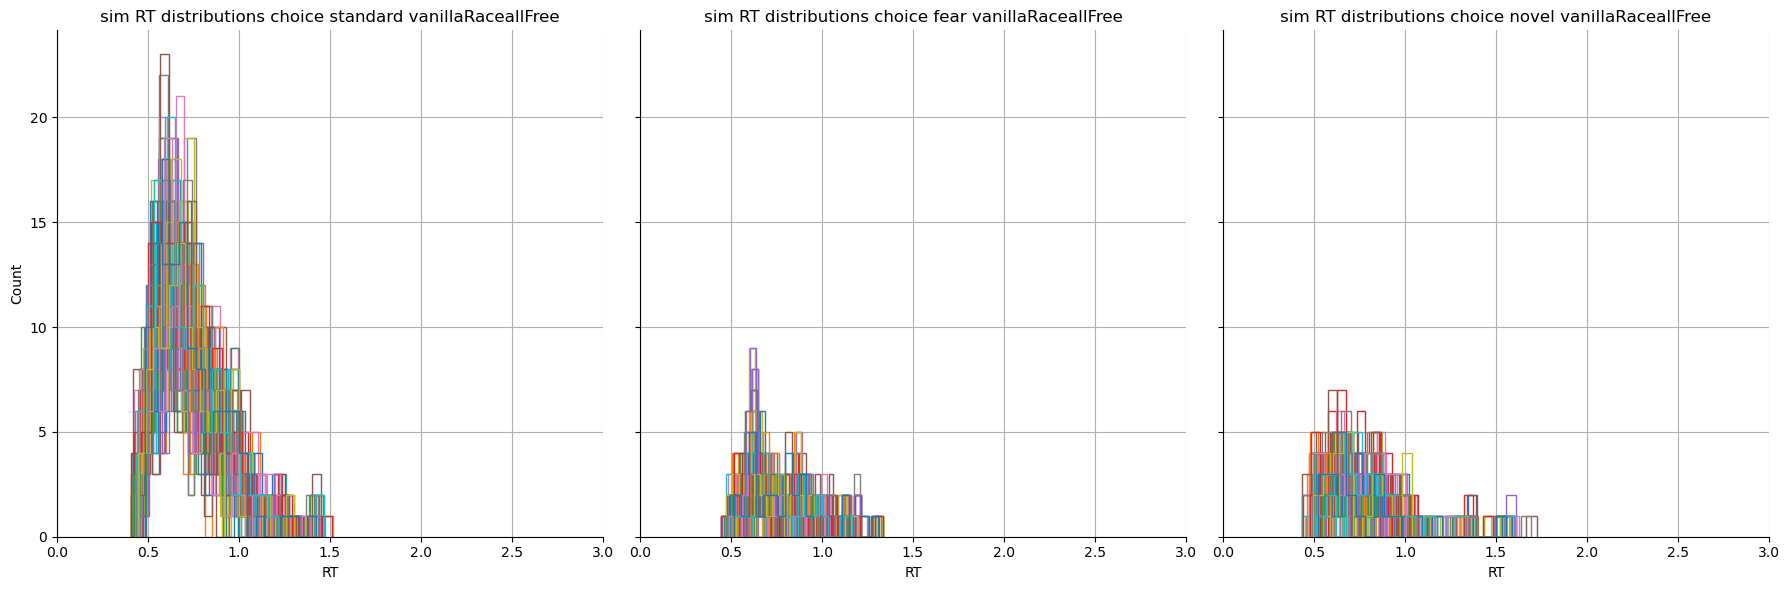

In [13]:
vanillaRACE3allFree_simData['rtPlot']=vanillaRACE3allFree_simData['rt']

# Filter data for each response type
dataResponse0 = vanillaRACE3allFree_simData.loc[vanillaRACE3allFree_simData['response'] == 0]
dataResponse1 = vanillaRACE3allFree_simData.loc[vanillaRACE3allFree_simData['response'] == 1]
dataResponse2 = vanillaRACE3allFree_simData.loc[vanillaRACE3allFree_simData['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaRaceallFree')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaRaceallFree')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaRaceallFree')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaRaceallFree.pdf')


## set up race model nuts numpyro

In [29]:
basepath

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data'

In [14]:
networkPath=basepath + r"/race_3_no_bias_lan_f2d991a6635b11efb6b1a0423f3e9b4e_torch_model.onnx"
networkPath

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/race_3_no_bias_lan_f2d991a6635b11efb6b1a0423f3e9b4e_torch_model.onnx'

In [15]:
simple_race_model_hier_all_noPrior = hssm.HSSM(
    data=vanillaRACE3allFree_simData,
    model="race_no_bias_3",
    hierarchical=True,
    loglik_kind="approx_differentiable",
    model_config = {
        "list_params": ["v0", "v1", "v2", "a", "z", "t"],
        "bounds": {
            "v0":  (0.0, 2.5),
            "v1": (0.0, 2.5),
            "v2": (0.0, 2.5),
            "a": (1.0, 3.0),
            "z": (0.0, 0.9),
            "t": (0.001, 2),
        },
        "backend": "jax",
    },
    choices=3,
    loglik = networkPath,
    p_outlier = 0,)


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


In [16]:
pathlib.Path(basepath+'/models/race/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_race_model_hier_all_noPrior=simple_race_model_hier_all_noPrior.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=1,
    draws=3000,
    tune=1000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

fileName = basepath + '/models/race/sept24/numpyro/inferenceData_sim_simple_race_model_hier_all_noPrior.nc'
data = inferenceData_simple_race_model_hier_all_noPrior
az.to_netcdf(data, fileName)


Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

In [23]:
fileName = basepath + '/models/race/sept24/numpyro/inferenceData_sim_simple_race_model_hier_all_noPrior_new.nc'
race_inferenceData_sim=az.from_netcdf(fileName)
race_inferenceData_sim

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

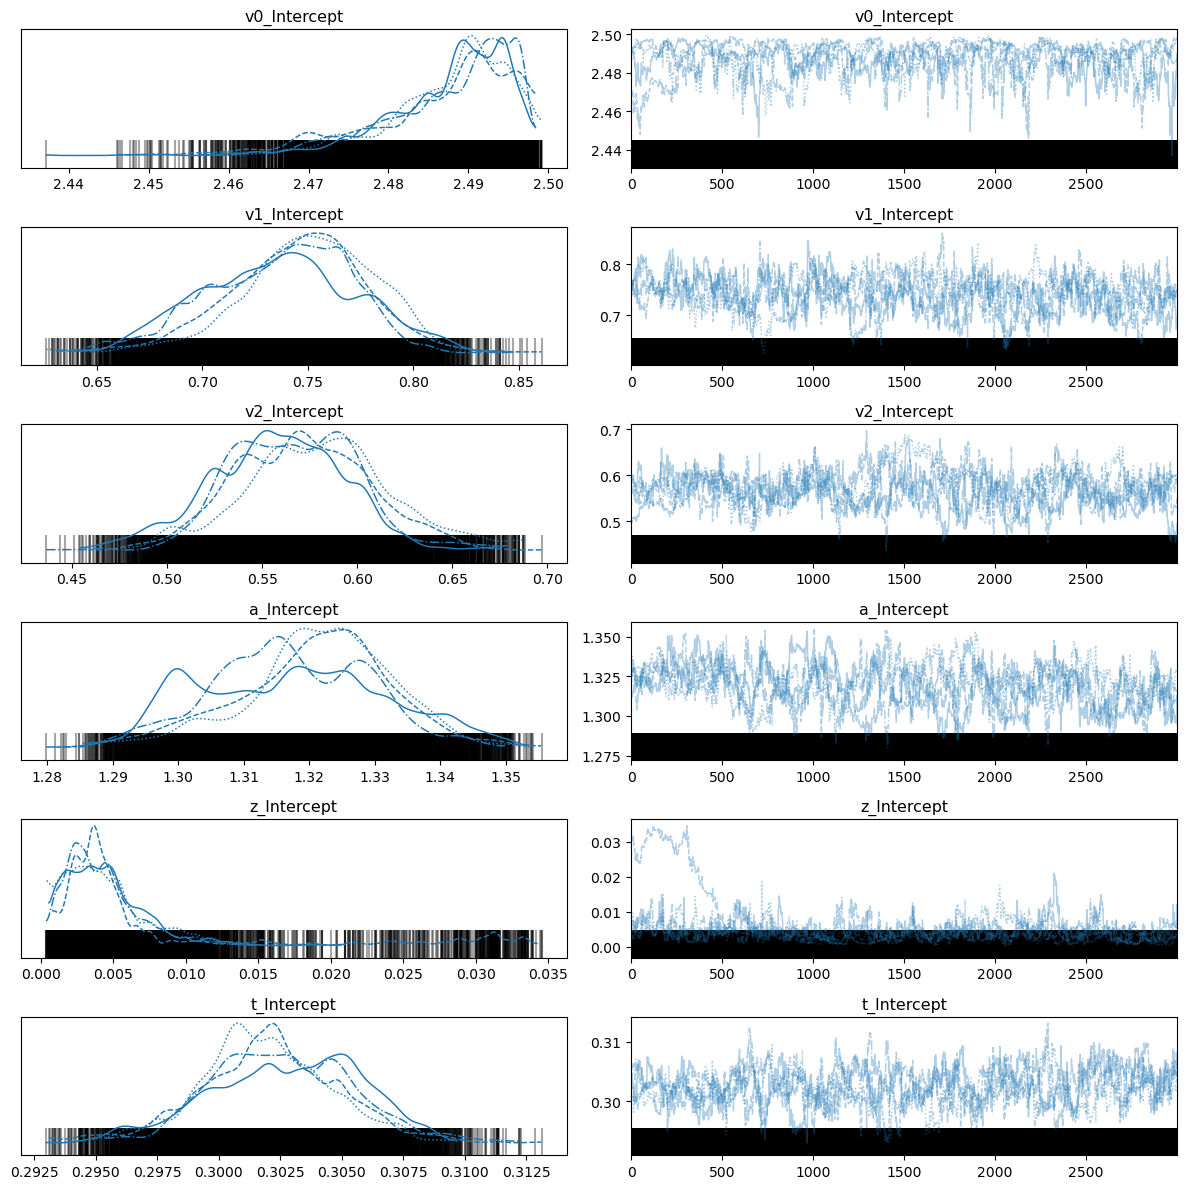

In [24]:
az.plot_trace(
    race_inferenceData_sim,var_names=['v0_Intercept',
                                                'v1_Intercept',
                                                'v2_Intercept',
                                                'a_Intercept',
                                                'z_Intercept',
                                                't_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='v1_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='v2_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='v0_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='v1_Intercept'>, <Axes: xlabel='v2_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

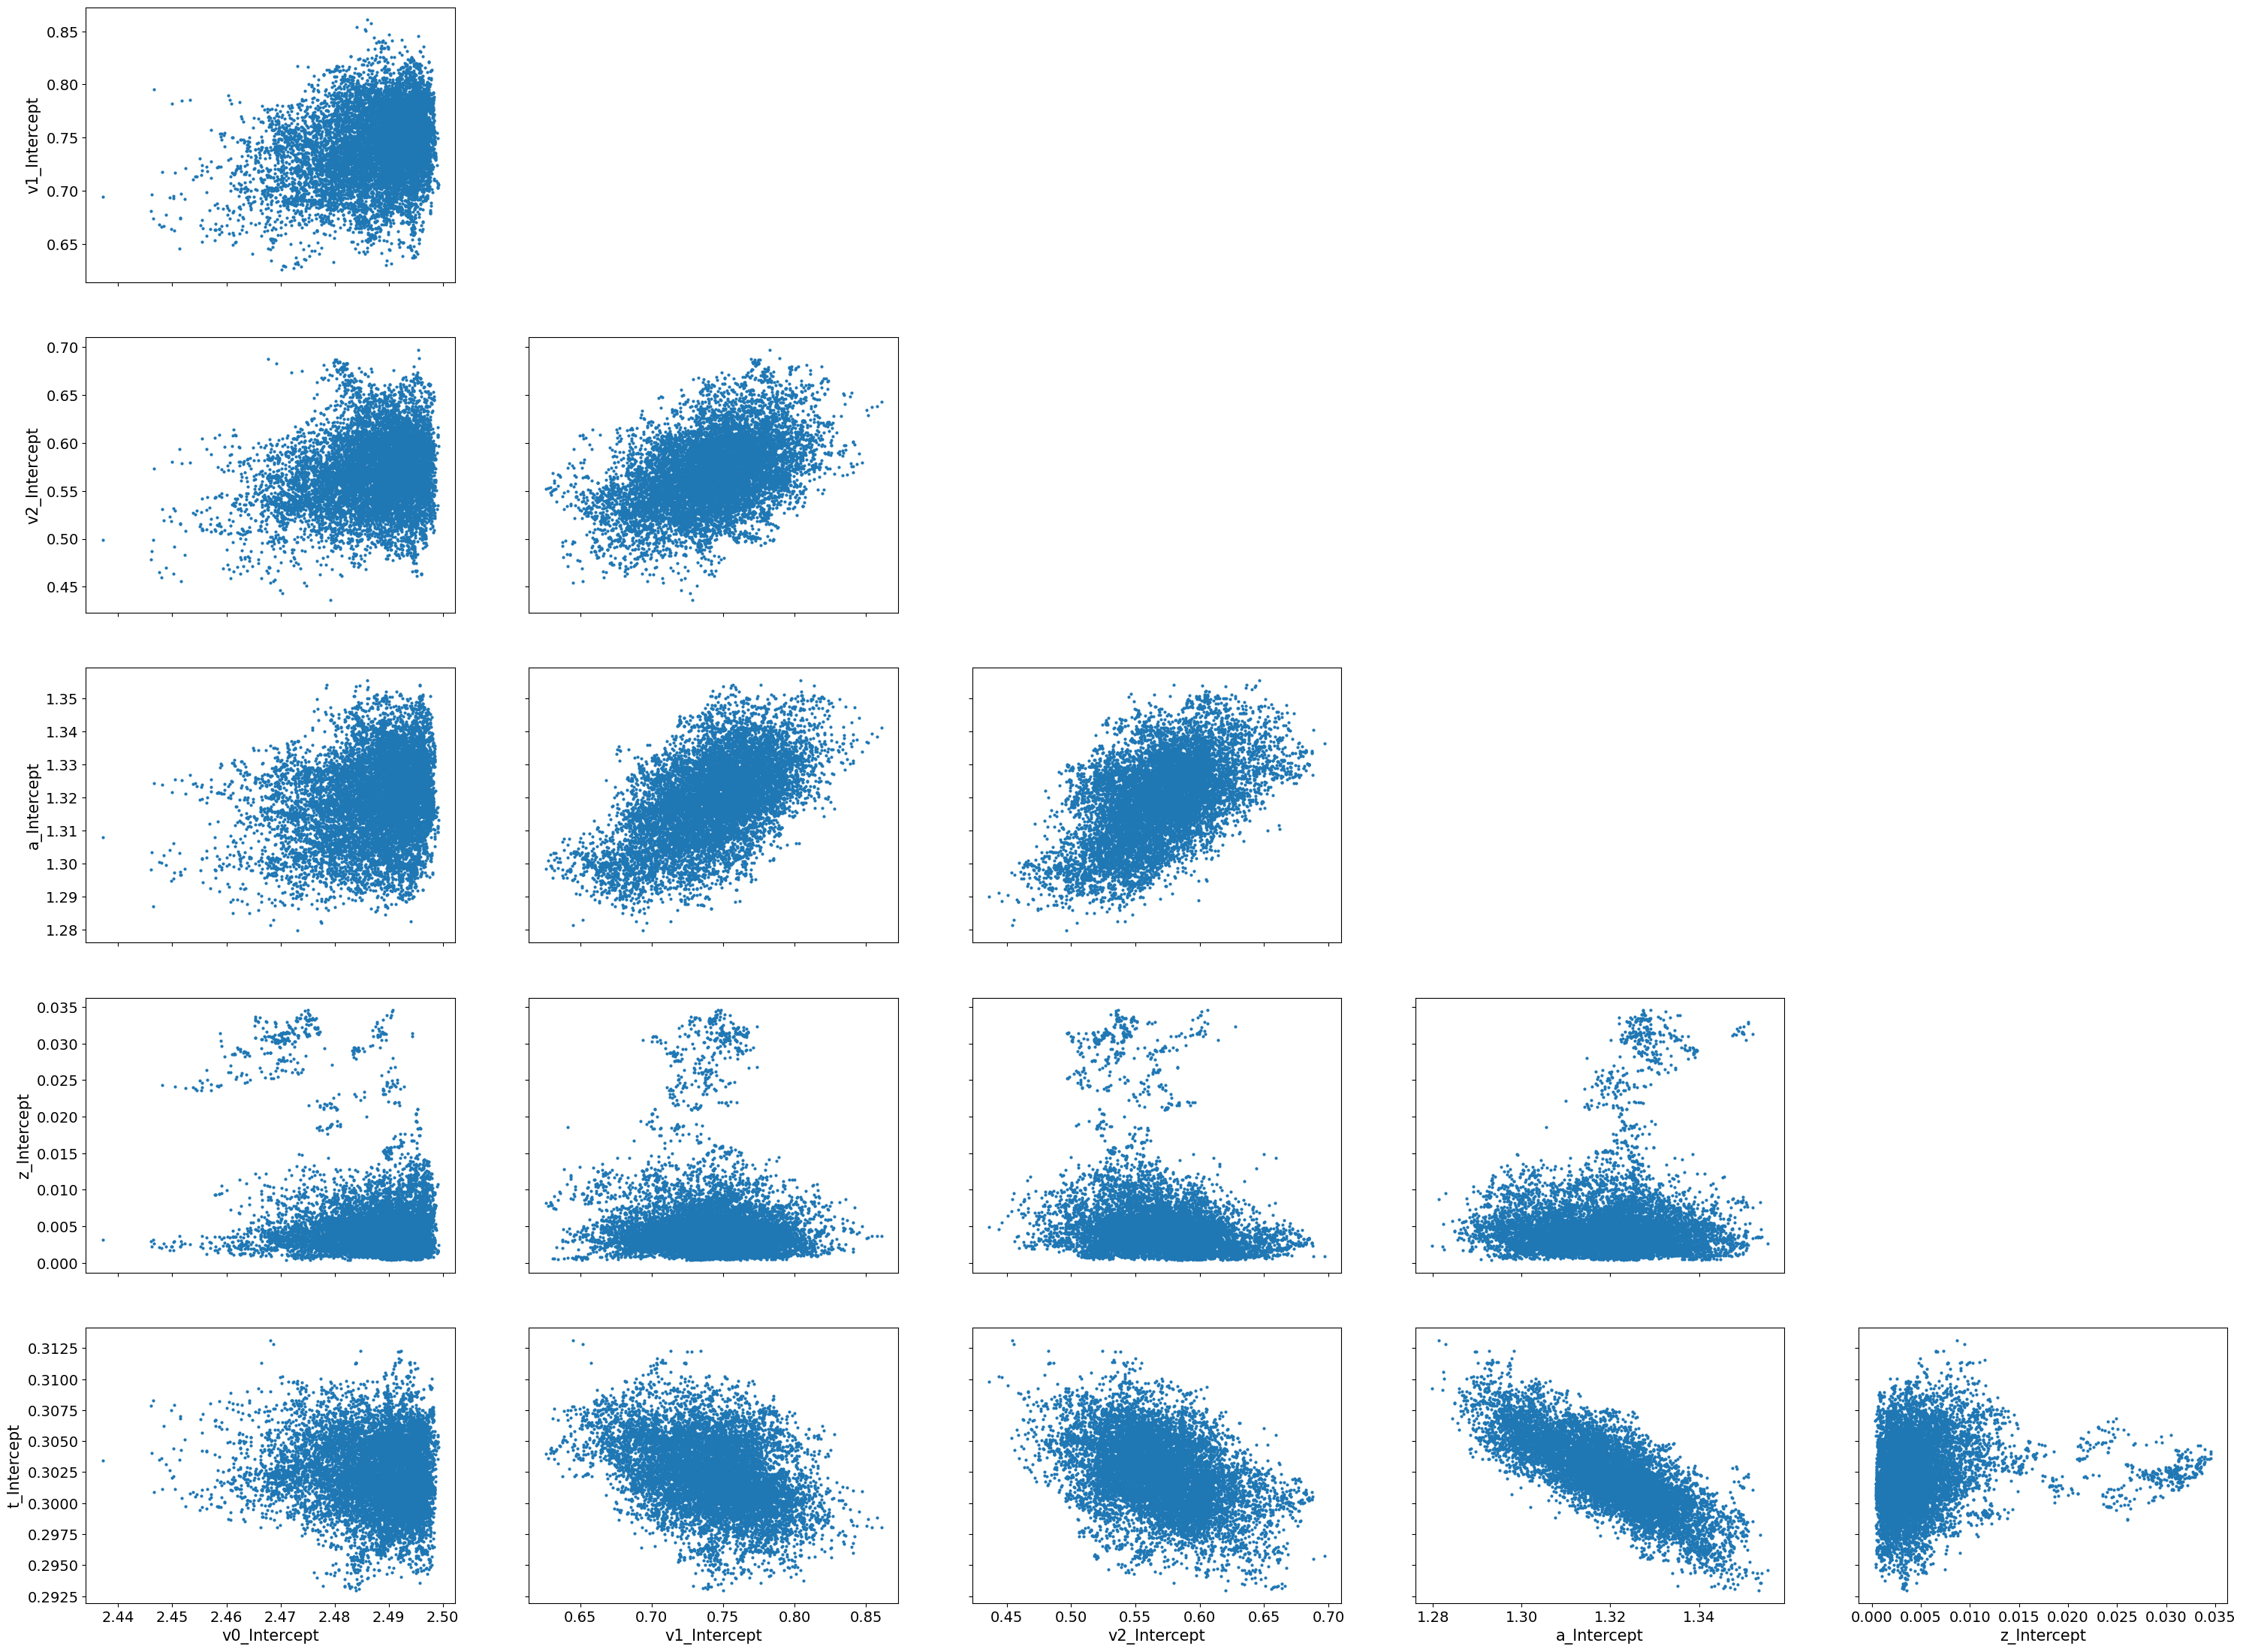

In [25]:
az.plot_pair(
    race_inferenceData_sim,var_names=['v0_Intercept',
                                                'v1_Intercept',
                                                'v2_Intercept',
                                                'a_Intercept',
                                                'z_Intercept',
                                                't_Intercept']
)

### play around with the ground truth params to simulate data with more errors

In [37]:
vanillaRACE3allFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2Choice.loc[oddballDataDay2Choice['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    
    # Specify parameters based on gaussians using stats from the model fit with real data
    v0_true, v1_true, v2_true, a_true, z_true, t_true = [np.random.normal(1,0.01), 
                                                         np.random.normal(1,0.01),
                                                         np.random.normal(1,0.01),
                                                         np.random.normal(2,0.01),
                                                         np.random.normal(0.5,0),
                                                         np.random.normal(0.3,0.01)]

#     v0_true, v1_true, v2_true, a_true, z_true = [1/3, 
#                                                  1/3, 
#                                                  1/3,
#                                                  0.5,
#                                                  0.2]
    # Simulate data
    sim_out = simulator(
        theta=[v0_true, v1_true, v2_true, a_true, z_true, t_true],  # parameter list
        model="race_no_bias_3",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaRACE3allFree_simDataEvenChoice=pd.concat([vanillaRACE3allFree_simDataEvenChoice, subDataset], ignore_index=True)

In [95]:
vanillaRACE3allFree_simDataEvenChoice

participant_id        rt  response
0             42013.0  0.972493       2.0
1             42013.0  0.805309       1.0
2             42013.0  1.071255       1.0
3             42013.0  0.825671       0.0
4             42013.0  0.657900       2.0
...               ...       ...       ...
11159         62433.0  0.921349       2.0
11160         62433.0  1.267080       0.0
11161         62433.0  0.842959       0.0
11162         62433.0  0.950048       0.0
11163         62433.0  1.055738       0.0

[11164 rows x 3 columns]

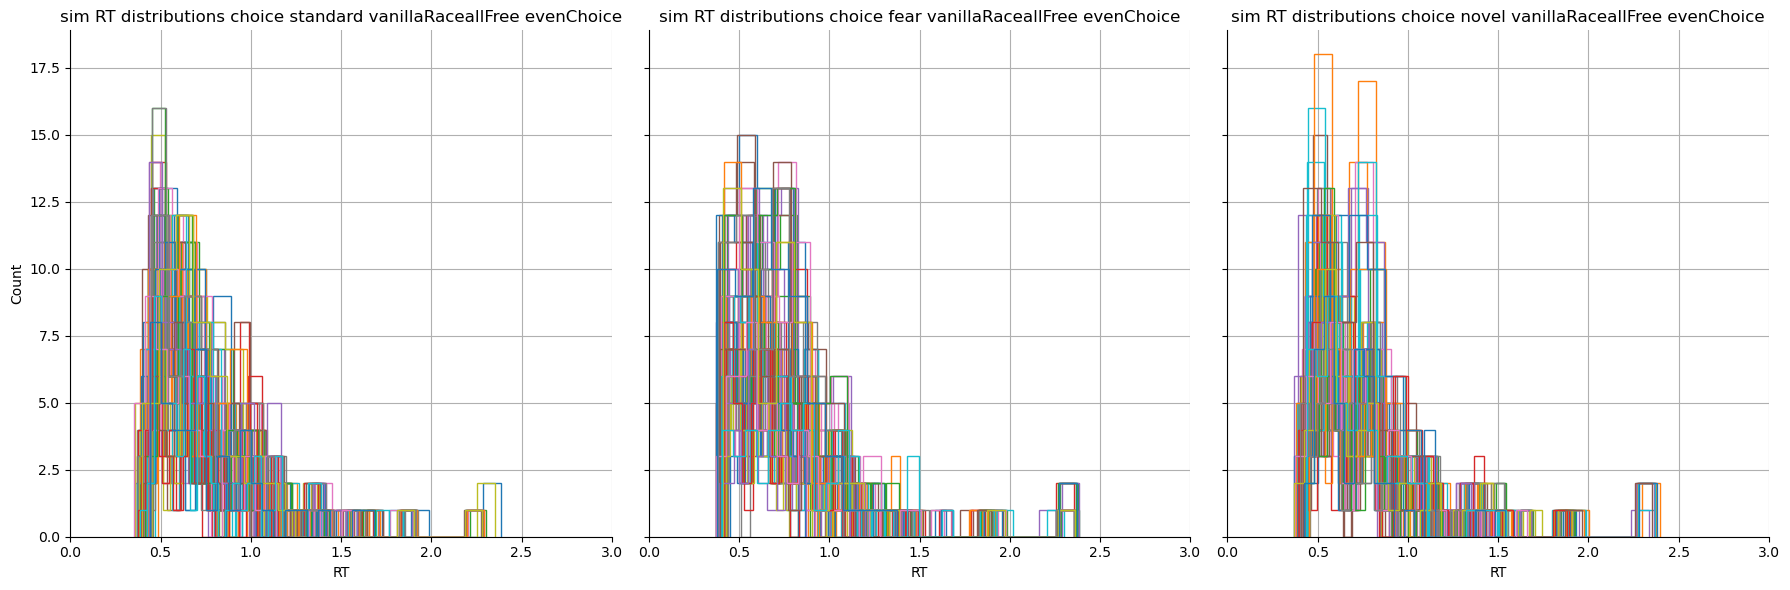

In [38]:
vanillaRACE3allFree_simDataEvenChoice['rtPlot']=vanillaRACE3allFree_simDataEvenChoice['rt']

# Filter data for each response type
dataResponse0 = vanillaRACE3allFree_simDataEvenChoice.loc[vanillaRACE3allFree_simDataEvenChoice['response'] == 0]
dataResponse1 = vanillaRACE3allFree_simDataEvenChoice.loc[vanillaRACE3allFree_simDataEvenChoice['response'] == 1]
dataResponse2 = vanillaRACE3allFree_simDataEvenChoice.loc[vanillaRACE3allFree_simDataEvenChoice['response'] == 2]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for response == 0
for i, subj_data in dataResponse0.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
axes[0].set_title('sim RT distributions choice standard vanillaRaceallFree evenChoice')
axes[0].set_xlabel('RT')
axes[0].set_ylabel('Count')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0, 3)

# Plot for response == 1
for i, subj_data in dataResponse1.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
axes[1].set_title('sim RT distributions choice fear vanillaRaceallFree evenChoice')
axes[1].set_xlabel('RT')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlim(0, 3)

# Plot for response == 2
for i, subj_data in dataResponse2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
axes[2].set_title('sim RT distributions choice novel vanillaRaceallFree evenChoice')
axes[2].set_xlabel('RT')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlim(0, 3)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(basepath + '/figures/sim_subRT_dist_all_choices_vanillaRaceallFree_evenChoice.pdf')


In [ ]:
networkPath=basepath + r"/race_3_no_bias_lan_f2d991a6635b11efb6b1a0423f3e9b4e_torch_model.onnx"
networkPath

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/race_3_no_bias_lan_f2d991a6635b11efb6b1a0423f3e9b4e_torch_model.onnx'

In [ ]:
simple_race_model_hier_all_noPrior = hssm.HSSM(
    data=vanillaRACE3allFree_simData,
    model="race_no_bias_3",
    hierarchical=True,
    loglik_kind="approx_differentiable",
    model_config = {
        "list_params": ["v0", "v1", "v2", "a", "z", "t"],
        "bounds": {
            "v0":  (0.0, 2.5),
            "v1": (0.0, 2.5),
            "v2": (0.0, 2.5),
            "a": (1.0, 3.0),
            "z": (0.0, 0.9),
            "t": (0.001, 2),
        },
        "backend": "jax",
    },
    choices=3,
    loglik = networkPath,
    p_outlier = 0,)


You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


In [ ]:
pathlib.Path(basepath+'/models/race/sept24/numpyro/').mkdir(parents=True, exist_ok=True)

inferenceData_simple_race_model_hier_all_noPrior=simple_race_model_hier_all_noPrior.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=1,
    draws=400,
    tune=400,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=False),)

fileName = basepath + '/models/race/sept24/numpyro/inferenceData_sim_simple_race_model_hier_all_noPrior.nc'
data = inferenceData_simple_race_model_hier_all_noPrior
az.to_netcdf(data, fileName)


Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/miniconda3/envs/hssm_cpu/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/softw

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/race/sept24/numpyro/inferenceData_sim_simple_race_model_hier_all_noPrior.nc'

In [26]:
fileName = basepath + '/models/race/sept24/numpyro/inferenceData_sim_evenChoice_simple_race_model_hier_all_noPrior_new.nc'
race_inferenceData_sim_evenChoice=az.from_netcdf(fileName)
race_inferenceData_sim_evenChoice

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

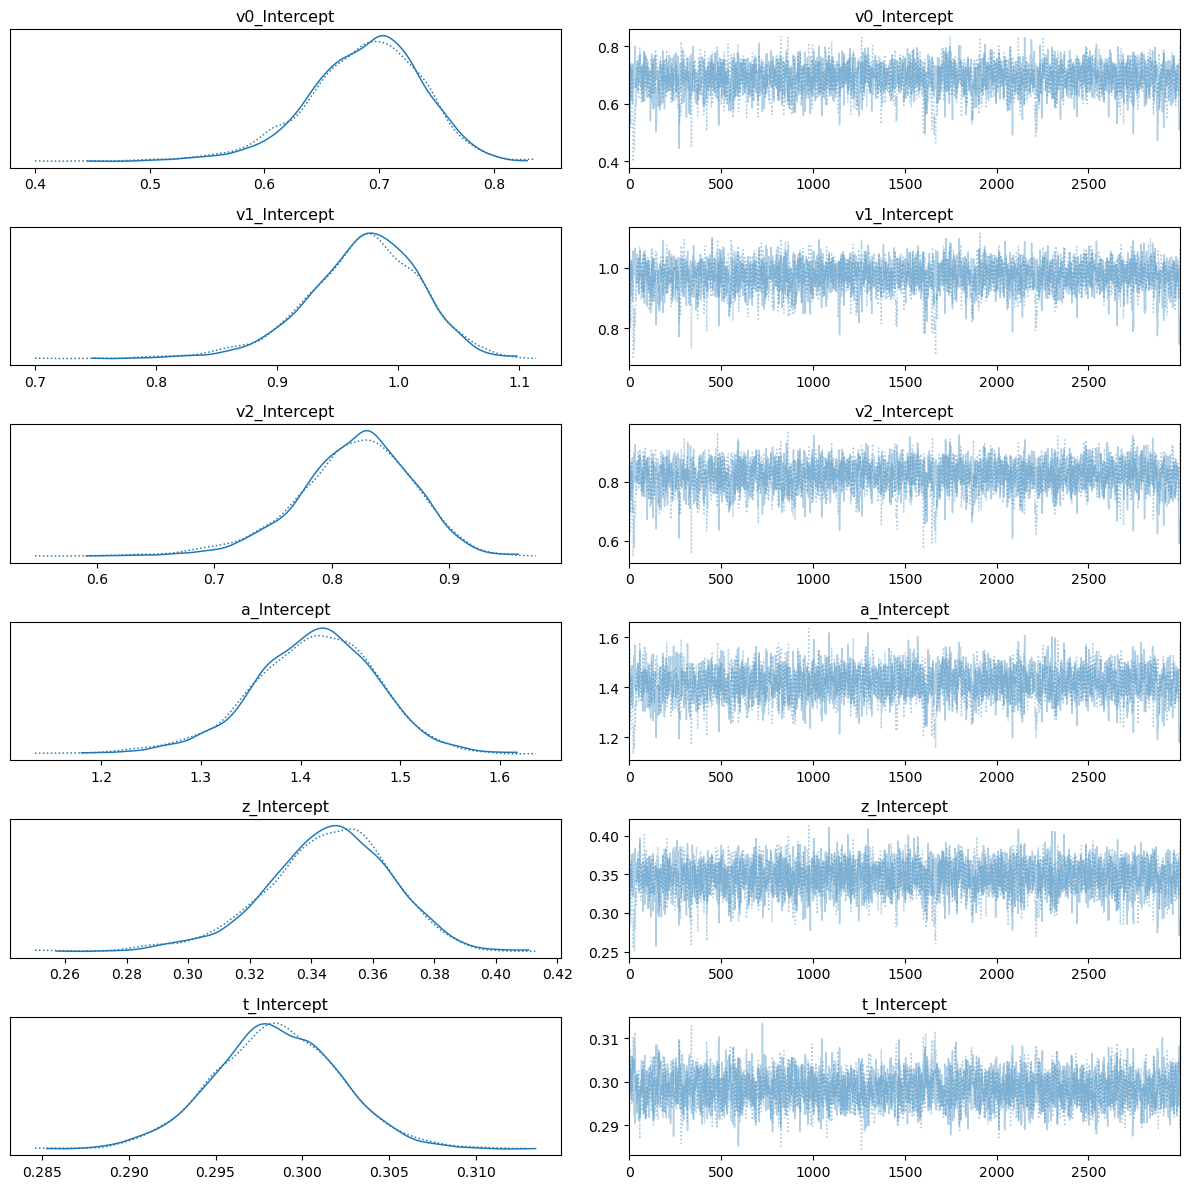

In [27]:
az.plot_trace(
    race_inferenceData_sim_evenChoice,var_names=['v0_Intercept',
                                                'v1_Intercept',
                                                'v2_Intercept',
                                                'a_Intercept',
                                                'z_Intercept',
                                                't_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='v1_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='v2_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='v0_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='v1_Intercept'>, <Axes: xlabel='v2_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

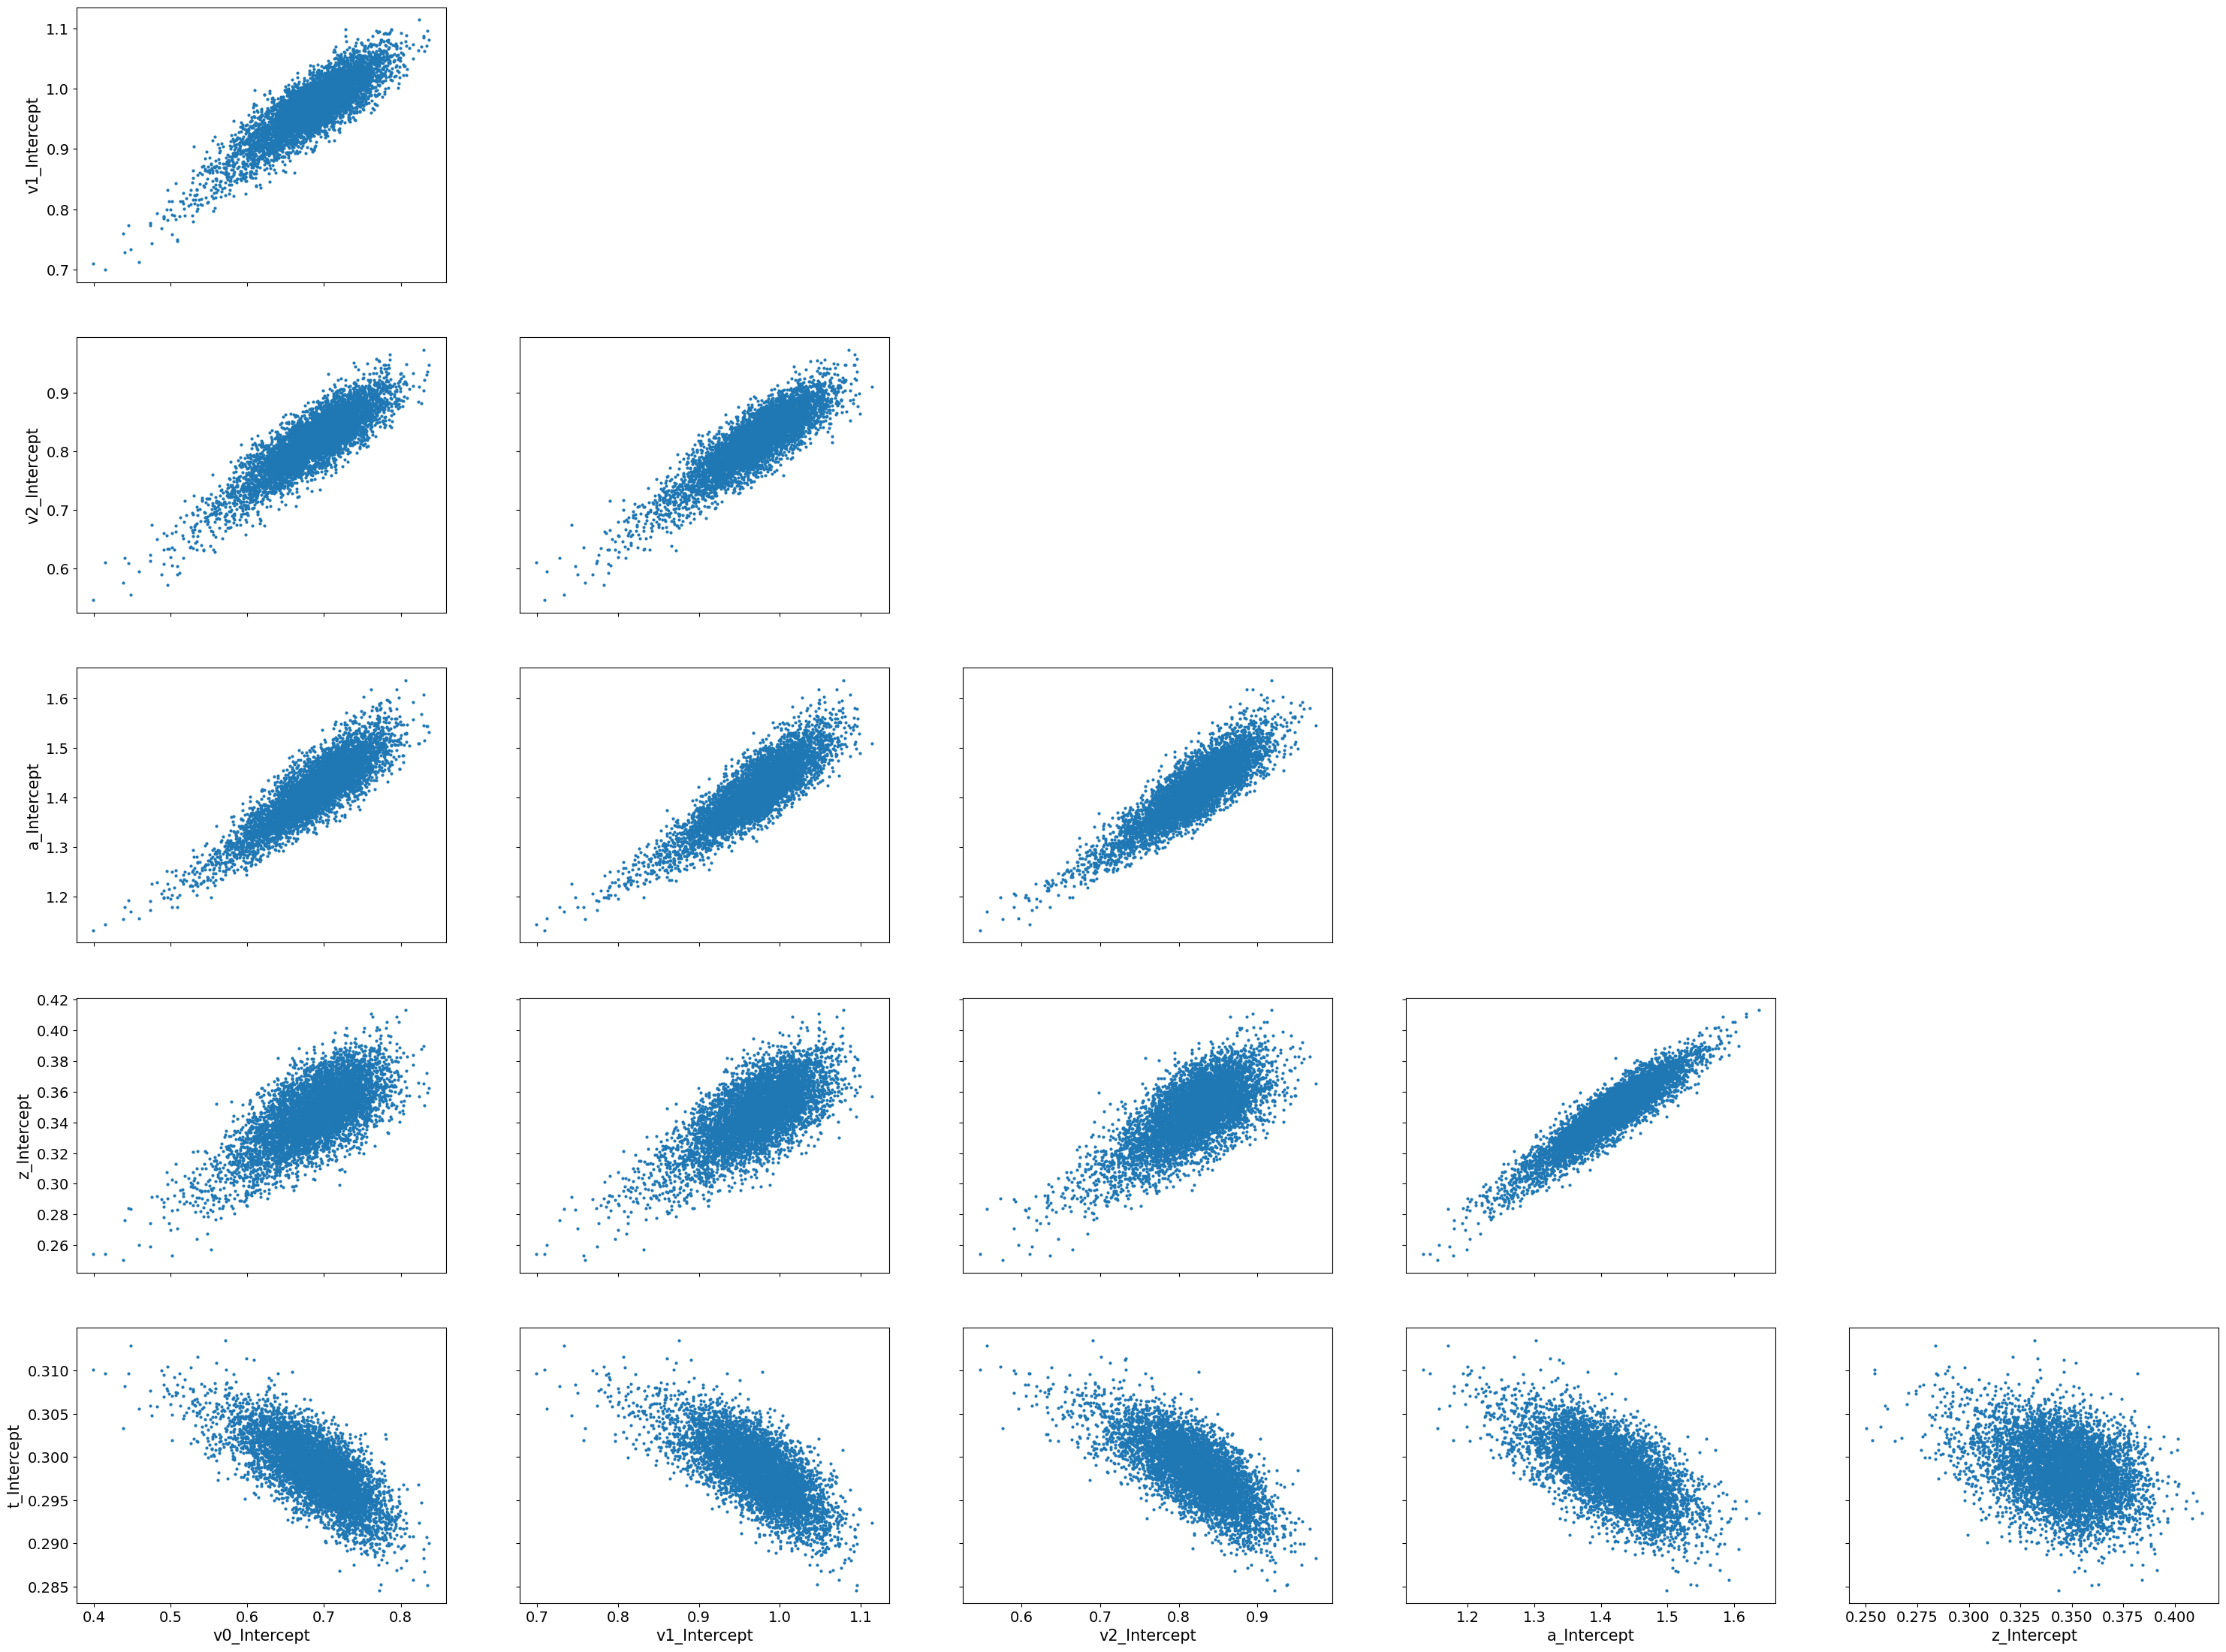

In [28]:
az.plot_pair(
    race_inferenceData_sim_evenChoice,var_names=['v0_Intercept',
                                                'v1_Intercept',
                                                'v2_Intercept',
                                                'a_Intercept',
                                                'z_Intercept',
                                                't_Intercept']
)

# no hier all data

In [29]:
fileName = basepath + '/models/race/sept24/numpyro/inferenceData_sim_simple_race_model_noHier.nc'
race_inferenceData_noHier=az.from_netcdf(fileName)
race_inferenceData_noHier

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [33]:
az.summary(race_inferenceData_noHier,var_names=['v0',
                                                'v1',
                                                'v2',
                                                'a',
                                                'z',
                                                't']
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v0  2.492  0.008   2.478    2.500        0.0      0.0    5842.0    4312.0   
v1  0.912  0.027   0.861    0.961        0.0      0.0    5754.0    6770.0   
v2  0.932  0.026   0.882    0.979        0.0      0.0    5776.0    6906.0   
a   1.695  0.015   1.667    1.722        0.0      0.0    4369.0    4702.0   
z   0.002  0.002   0.000    0.005        0.0      0.0    6790.0    4401.0   
t   0.303  0.004   0.296    0.310        0.0      0.0    4973.0    5408.0   

    r_hat  
v0    1.0  
v1    1.0  
v2    1.0  
a     1.0  
z     1.0  
t     1.0

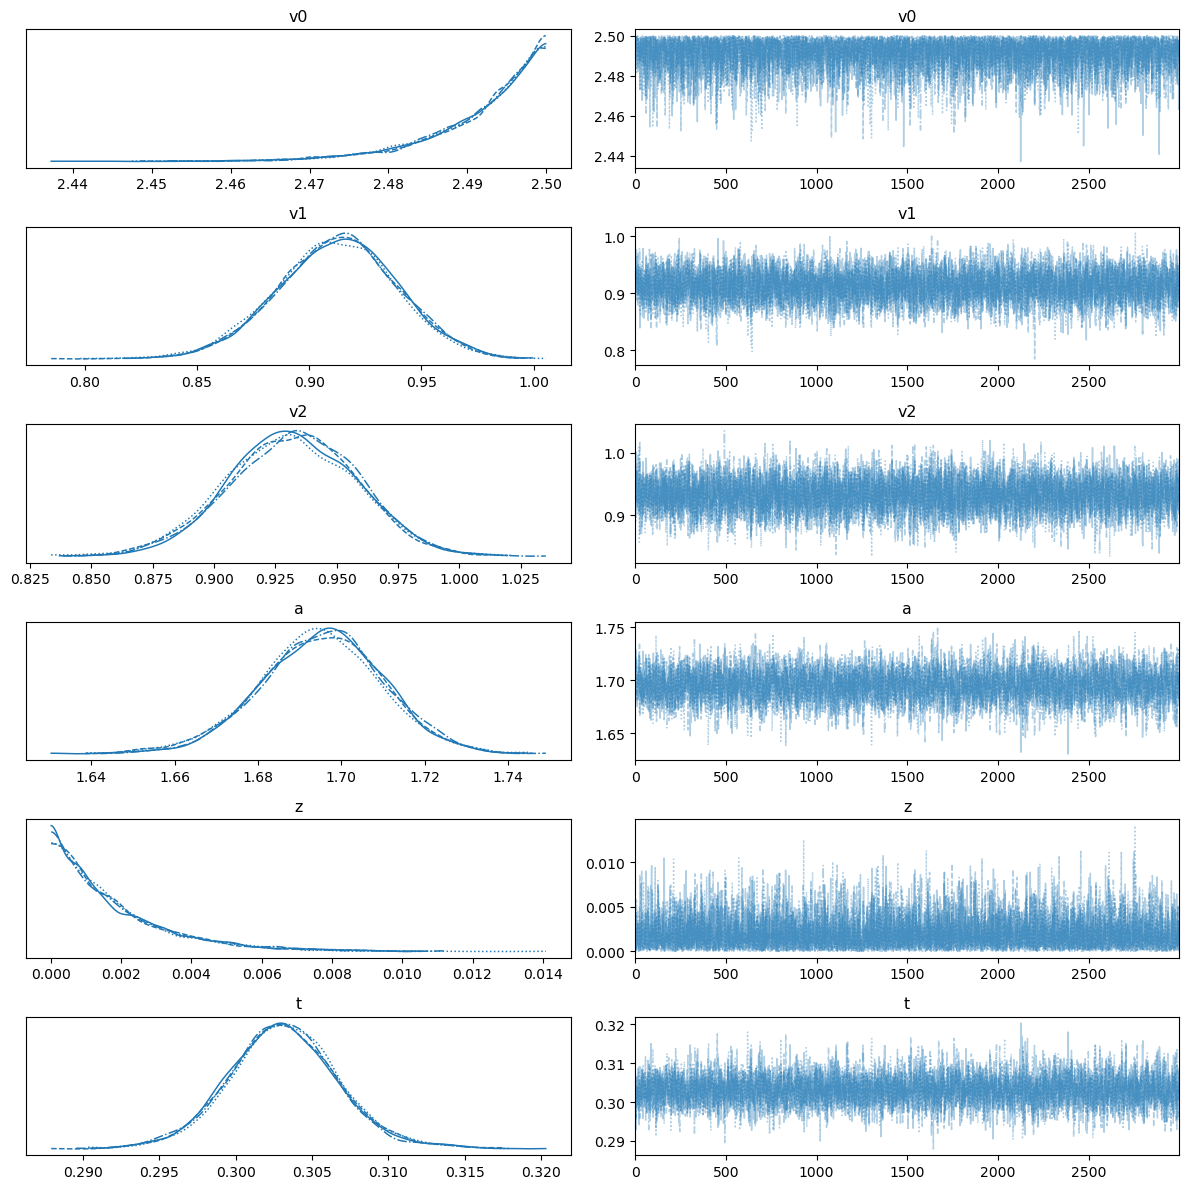

In [30]:
az.plot_trace(
    race_inferenceData_noHier,var_names=['v0',
                                                'v1',
                                                'v2',
                                                'a',
                                                'z',
                                                't']
)
plt.tight_layout()

array([[<Axes: ylabel='v1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='a'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='z'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='v0', ylabel='t'>, <Axes: xlabel='v1'>,
        <Axes: xlabel='v2'>, <Axes: xlabel='a'>, <Axes: xlabel='z'>]],
      dtype=object)

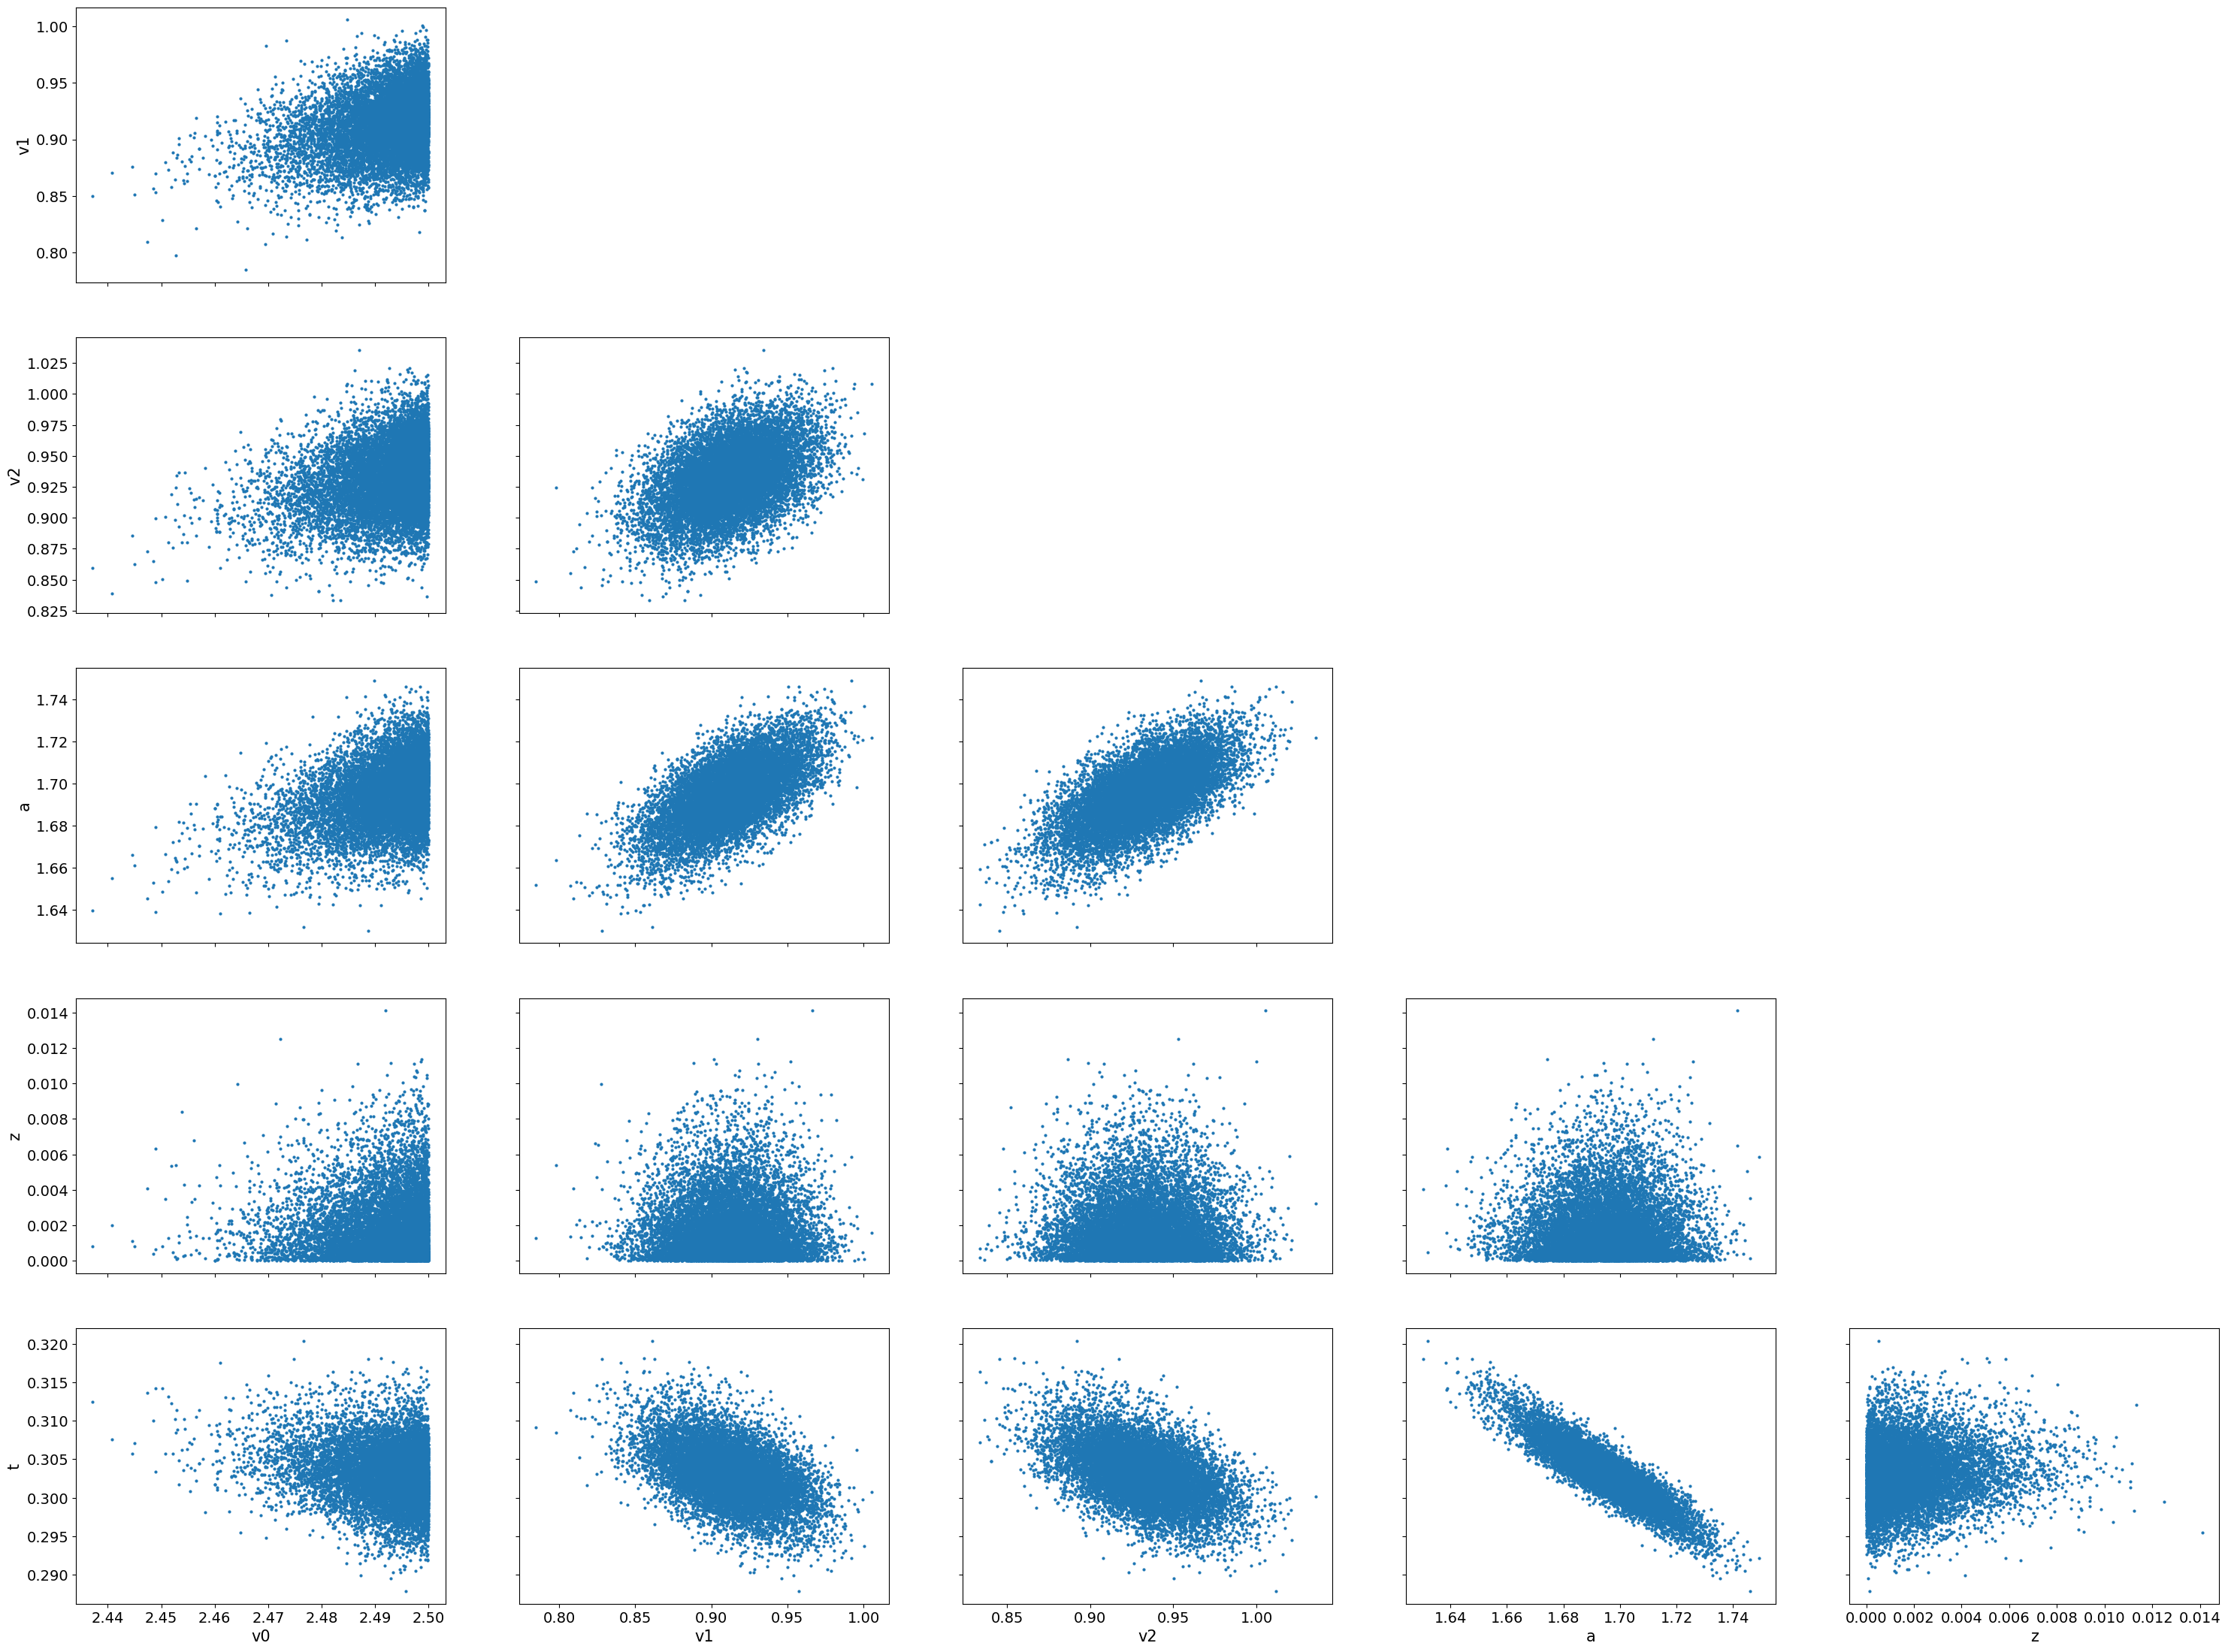

In [31]:
az.plot_pair(
    race_inferenceData_noHier,var_names=['v0',
                                                'v1',
                                                'v2',
                                                'a',
                                                'z',
                                                't']
)

# check single sub data

In [2]:
subID = day2SubList[0]
fileName = basepath + '/models/race/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_race_simple_allFree' + str(subID) + '.nc'
race_inferenceData_singleSub = az.from_netcdf(fileName)
race_inferenceData_singleSub 

NameError: name 'day2SubList' is not defined

In [14]:
skipped_subjects_traces = []
for subNum in range(70, 71):
    try:
        subID = day2SubList[subNum]
        fileName = basepath + '/models/race/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_race_simple_allFree' + str(subID) + '.nc'
        race_inferenceData_singleSub = az.from_netcdf(fileName)
        
        # Plotting trace
        az.plot_trace(race_inferenceData_singleSub, var_names=["v0", "v1", "v2", "a", "z", "t"])
        plt.tight_layout()
        
        # Saving the plot
        plt.savefig(basepath + '/models/race/sept24/numpyro/singleSub/' + str(subID) + '/singleSub_traces_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    except OverflowError as e:
        print(f"Skipping subID {subID}: {e}")
        skipped_subjects_traces.append(subID)
         # Close the plot to prevent it from displaying
        plt.close()
    except Exception as e:
        print(f"An unexpected error occurred for subID {subID}: {e}")
         # Close the plot to prevent it from displaying
        skipped_subjects_traces.append(subID)
        plt.close()

In [22]:
print("Skipped subjects for trace plots:", skipped_subjects_traces)


Skipped subjects for trace plots: []


In [15]:
skipped_subjects_pair = []
for subNum in range(70, 71):
    try:
        subID = day2SubList[subNum]
        fileName = basepath + '/models/race/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_race_simple_allFree' + str(subID) + '.nc'
        race_inferenceData_singleSub = az.from_netcdf(fileName)
        
        # Plotting posterior pair
        az.plot_pair(race_inferenceData_singleSub,var_names=["v0", "v1", "v2", "a", "z", "t"])
        plt.tight_layout()
        
        # Saving the plot
        plt.savefig(basepath + '/models/race/sept24/numpyro/singleSub/' + str(subID) + '/singleSub_posteriorPair_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    except OverflowError as e:
        print(f"Skipping subID {subID}: {e}")
        skipped_subjects_pair.append(subID)
    except Exception as e:
        print(f"An unexpected error occurred for subID {subID}: {e}")
        skipped_subjects_pair.append(subID)

In [24]:
print("Skipped subjects for pair plots:", skipped_subjects_pair)

Skipped subjects for pair plots: []


## look at specific sub data based on inference results

### good subs

In [16]:
subIDs = [42023, 42073, 42133, 42183, 42233, 
    42253, 42423, 62273, 62283, 62433,62433,62133]
len(subIDs)

12

#### loop

In [17]:
subIDs = [42023, 42073, 42133, 42183, 42233, 
    42253, 42423, 62273, 62283, 62433,62133]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2Choice[oddballDataDay2Choice.participant_id==subID]

        # Filter data for each response type
        dataResponse0 = subAllData.loc[subAllData['response'] == 0]
        dataResponse1 = subAllData.loc[subAllData['response'] == 1]
        dataResponse2 = subAllData.loc[subAllData['response'] == 2]

        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Plot for response == 0
        for i, subj_data in dataResponse0.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
            axes[0].set_title('real RT distributions choice standard raw sub:'+ str(subID))
            axes[0].set_xlabel('RT')
            axes[0].set_ylabel('Count')
            axes[0].spines['top'].set_visible(False)
            axes[0].spines['right'].set_visible(False)
            axes[0].set_xlim(0, 3)

        # Plot for response == 1
        for i, subj_data in dataResponse1.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
            axes[1].set_title('real RT distributions choice fear raw sub:'+ str(subID))
            axes[1].set_xlabel('RT')
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            axes[1].set_xlim(0, 3)

        # Plot for response == 2
        for i, subj_data in dataResponse2.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
            axes[2].set_title('real RT distributions choice novel raw sub:'+ str(subID))
            axes[2].set_xlabel('RT')
            axes[2].spines['top'].set_visible(False)
            axes[2].spines['right'].set_visible(False)
            axes[2].set_xlim(0, 3)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(basepath + '/models/race/sept24/numpyro/singleSub/' + str(subID) + '/choiceRT_dist_plot_' + str(subID) + '.jpg')
        

        # Close the plot to prevent it from displaying
        plt.close()

    

42023
42073
42133
42183
42233
42253
42423
62273
62283
62433


#### big panel plot

Processing subject 42023
Processing subject 42073
Processing subject 42133
Processing subject 42183
Processing subject 42233
Processing subject 42253
Processing subject 42423
Processing subject 62273
Processing subject 62283
Processing subject 62433


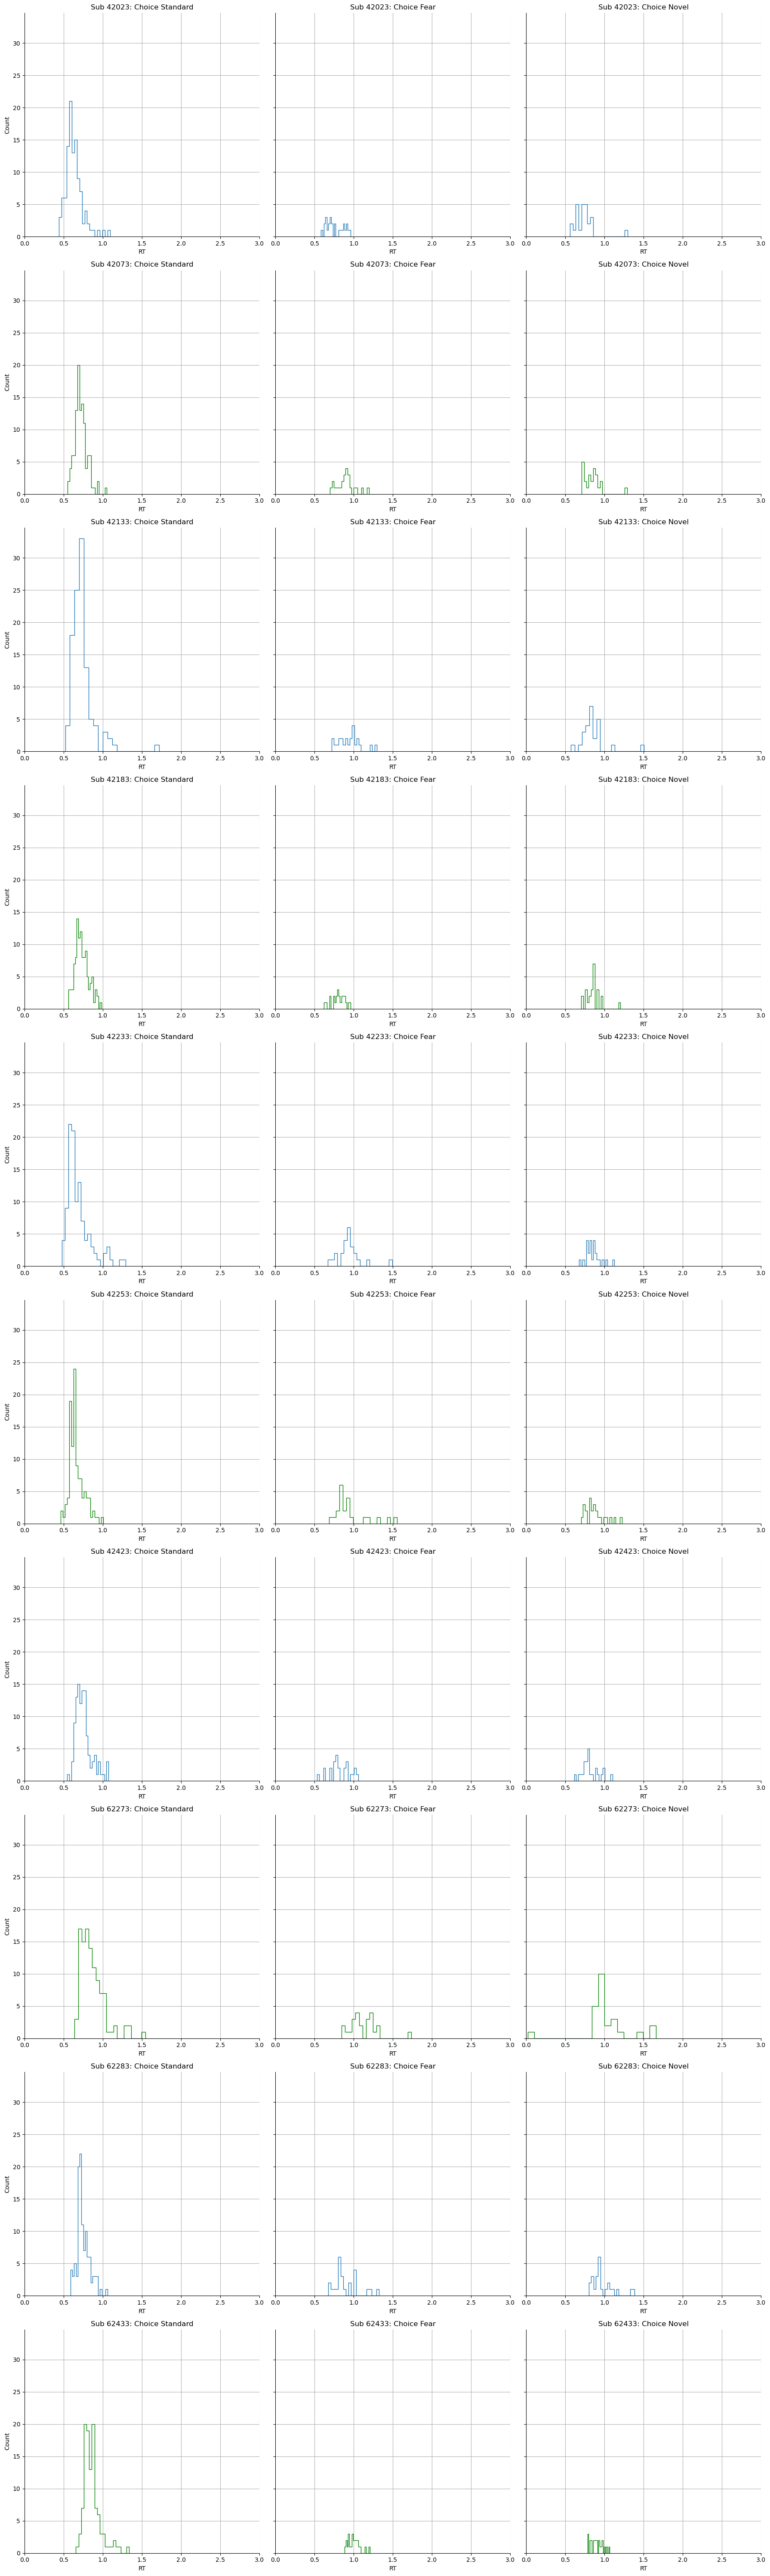

In [12]:
# List of subject IDs
subIDs = [42023, 42073, 42133, 42183, 42233, 42253, 42423, 62273, 62283, 62433]

n_subs = len(subIDs)
n_responses = 3  # 3 response types

# Create a figure with a grid of subplots, 3 columns for each response, and one row per subject
fig, axes = plt.subplots(n_subs, n_responses, figsize=(18, 6 * n_subs), sharey=True)

# Flatten the axes to make it easier to index
axes = axes.reshape(n_subs, n_responses)


for s in range(n_subs):
    subID = subIDs[s]
    print(f"Processing subject {subID}")

    # Extract data for the current subject
    subAllData = oddballDataDay2Choice[oddballDataDay2Choice.participant_id == subID]

    # Filter data for each response type
    dataResponse0 = subAllData.loc[subAllData['response'] == 0]
    dataResponse1 = subAllData.loc[subAllData['response'] == 1]
    dataResponse2 = subAllData.loc[subAllData['response'] == 2]

    trace_color = 'green' if s % 2 == 1 else None
    # Alternate row background color
    
    
    # Plot for response == 0
    for i, subj_data in dataResponse0.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 0], color=trace_color)
        axes[s, 0].set_title(f'Sub {subID}: Choice Standard')
        axes[s, 0].set_xlabel('RT')
        axes[s, 0].set_ylabel('Count')
        axes[s, 0].spines['top'].set_visible(False)
        axes[s, 0].spines['right'].set_visible(False)
        axes[s, 0].set_xlim(0, 3)

    # Plot for response == 1
    for i, subj_data in dataResponse1.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 1], color=trace_color)
        axes[s, 1].set_title(f'Sub {subID}: Choice Fear')
        axes[s, 1].set_xlabel('RT')
        axes[s, 1].spines['top'].set_visible(False)
        axes[s, 1].spines['right'].set_visible(False)
        axes[s, 1].set_xlim(0, 3)

    # Plot for response == 2
    for i, subj_data in dataResponse2.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 2], color=trace_color)
        axes[s, 2].set_title(f'Sub {subID}: Choice Novel')
        axes[s, 2].set_xlabel('RT')
        axes[s, 2].spines['top'].set_visible(False)
        axes[s, 2].spines['right'].set_visible(False)
        axes[s, 2].set_xlim(0, 3)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the entire panel figure
plt.savefig(basepath + '/models/race/sept24/numpyro/betterSubs_RT_dist_plots_combined.jpg')



### param trade off subs

#### loop

In [15]:
subIDs = [42013, 42043, 42053, 42083, 42103, 42123, 42143, 42153, 42173, 42213,
    42263, 42273, 42283, 42293, 42313, 42353, 42373, 42383, 42403, 42413,
    62013, 62043, 62103, 62143, 62153, 62163, 62173, 62193, 62233,
    62253, 62293, 62303, 62313, 62323, 62363, 62373, 62393, 62403, 62423,
    ]
len(subIDs)

39

In [13]:
subIDs = [42013, 42043, 42053, 42083, 42103, 42123, 42143, 42153, 42173, 42213,
    42263, 42273, 42283, 42293, 42313, 42353, 42373, 42383, 42403, 42413,
    62013, 62043, 62103, 62143, 62153, 62163, 62173, 62193, 62233,
    62253, 62293, 62303, 62313, 62323, 62363, 62373, 62393, 62403, 62423,
    ]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2Choice[oddballDataDay2Choice.participant_id==subID]

        # Filter data for each response type
        dataResponse0 = subAllData.loc[subAllData['response'] == 0]
        dataResponse1 = subAllData.loc[subAllData['response'] == 1]
        dataResponse2 = subAllData.loc[subAllData['response'] == 2]

        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Plot for response == 0
        for i, subj_data in dataResponse0.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
            axes[0].set_title('real RT distributions choice standard raw sub:'+ str(subID))
            axes[0].set_xlabel('RT')
            axes[0].set_ylabel('Count')
            axes[0].spines['top'].set_visible(False)
            axes[0].spines['right'].set_visible(False)
            axes[0].set_xlim(0, 3)

        # Plot for response == 1
        for i, subj_data in dataResponse1.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
            axes[1].set_title('real RT distributions choice fear raw sub:'+ str(subID))
            axes[1].set_xlabel('RT')
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            axes[1].set_xlim(0, 3)

        # Plot for response == 2
        for i, subj_data in dataResponse2.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
            axes[2].set_title('real RT distributions choice novel raw sub:'+ str(subID))
            axes[2].set_xlabel('RT')
            axes[2].spines['top'].set_visible(False)
            axes[2].spines['right'].set_visible(False)
            axes[2].set_xlim(0, 3)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(basepath + '/models/race/sept24/numpyro/singleSub/' + str(subID) + '/choiceRT_dist_plot_' + str(subID) + '.jpg')
        

        # Close the plot to prevent it from displaying
        plt.close()

    

42013
42043
42053
42083
42103
42123
42143
42153
42173
42213
42263
42273
42283
42293
42313
42353
42373
42383
42403
42413
62013
62043
62103
62133
62143
62153
62163
62173
62193
62233
62253
62293
62303
62313
62323
62363
62373
62393
62403
62423
62433


#### big panel plot

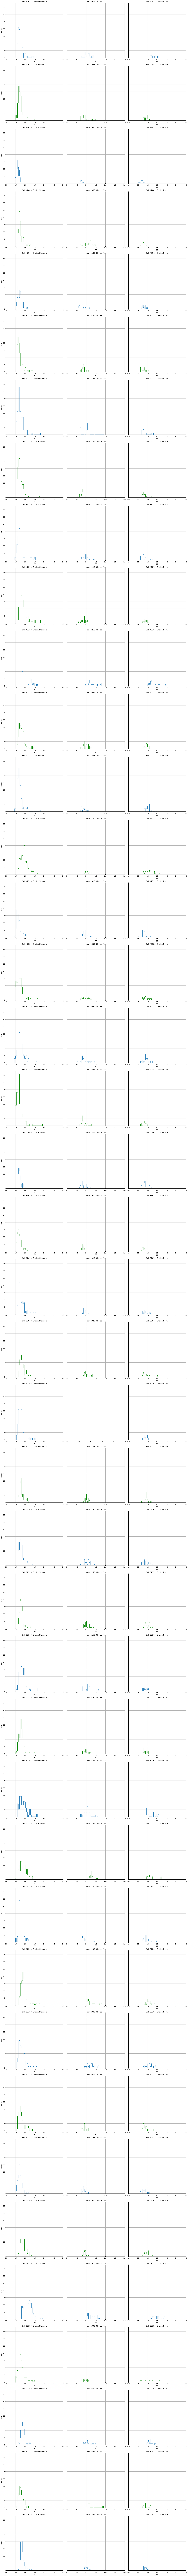

In [14]:
# List of subject IDs
subIDs = [42013, 42043, 42053, 42083, 42103, 42123, 42143, 42153, 42173, 42213,
    42263, 42273, 42283, 42293, 42313, 42353, 42373, 42383, 42403, 42413,
    62013, 62043, 62103, 62143, 62153, 62163, 62173, 62193, 62233,
    62253, 62293, 62303, 62313, 62323, 62363, 62373, 62393, 62403, 62423]

n_subs = len(subIDs)
n_responses = 3  # 3 response types

# Create a figure with a grid of subplots, 3 columns for each response, and one row per subject
fig, axes = plt.subplots(n_subs, n_responses, figsize=(18, 6 * n_subs), sharey=True)

# Flatten the axes to make it easier to index
axes = axes.reshape(n_subs, n_responses)


for s in range(n_subs):
    subID = subIDs[s]
    #print(f"Processing subject {subID}")

    # Extract data for the current subject
    subAllData = oddballDataDay2Choice[oddballDataDay2Choice.participant_id == subID]

    # Filter data for each response type
    dataResponse0 = subAllData.loc[subAllData['response'] == 0]
    dataResponse1 = subAllData.loc[subAllData['response'] == 1]
    dataResponse2 = subAllData.loc[subAllData['response'] == 2]

    trace_color = 'green' if s % 2 == 1 else None
    # Alternate row background color
    
    
    # Plot for response == 0
    for i, subj_data in dataResponse0.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 0], color=trace_color)
        axes[s, 0].set_title(f'Sub {subID}: Choice Standard')
        axes[s, 0].set_xlabel('RT')
        axes[s, 0].set_ylabel('Count')
        axes[s, 0].spines['top'].set_visible(False)
        axes[s, 0].spines['right'].set_visible(False)
        axes[s, 0].set_xlim(0, 3)

    # Plot for response == 1
    for i, subj_data in dataResponse1.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 1], color=trace_color)
        axes[s, 1].set_title(f'Sub {subID}: Choice Fear')
        axes[s, 1].set_xlabel('RT')
        axes[s, 1].spines['top'].set_visible(False)
        axes[s, 1].spines['right'].set_visible(False)
        axes[s, 1].set_xlim(0, 3)

    # Plot for response == 2
    for i, subj_data in dataResponse2.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 2], color=trace_color)
        axes[s, 2].set_title(f'Sub {subID}: Choice Novel')
        axes[s, 2].set_xlabel('RT')
        axes[s, 2].spines['top'].set_visible(False)
        axes[s, 2].spines['right'].set_visible(False)
        axes[s, 2].set_xlim(0, 3)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the entire panel figure
plt.savefig(basepath + '/models/race/sept24/numpyro/paramTradeOffSubs_RT_dist_plots_combined.jpg')



### clear a z trade off subs

In [17]:
subIDs = [42033, 42063, 42163, 42203, 42303, 42323, 42343, 42363, 42393, 
    62023, 62073, 62093, 62113, 62123, 62213, 62263, 62333, 62343, 
    62413]
len(subIDs)

19

#### loop

In [15]:
subIDs = [42033, 42063, 42163, 42203, 42303, 42323, 42343, 42363, 42393, 
    62023, 62073, 62093, 62113, 62123, 62213, 62263, 62333, 62343, 
    62413]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2Choice[oddballDataDay2Choice.participant_id==subID]

        # Filter data for each response type
        dataResponse0 = subAllData.loc[subAllData['response'] == 0]
        dataResponse1 = subAllData.loc[subAllData['response'] == 1]
        dataResponse2 = subAllData.loc[subAllData['response'] == 2]

        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

        # Plot for response == 0
        for i, subj_data in dataResponse0.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[0])
            axes[0].set_title('real RT distributions choice standard raw sub:'+ str(subID))
            axes[0].set_xlabel('RT')
            axes[0].set_ylabel('Count')
            axes[0].spines['top'].set_visible(False)
            axes[0].spines['right'].set_visible(False)
            axes[0].set_xlim(0, 3)

        # Plot for response == 1
        for i, subj_data in dataResponse1.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[1])
            axes[1].set_title('real RT distributions choice fear raw sub:'+ str(subID))
            axes[1].set_xlabel('RT')
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            axes[1].set_xlim(0, 3)

        # Plot for response == 2
        for i, subj_data in dataResponse2.groupby('participant_id'):
            subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[2])
            axes[2].set_title('real RT distributions choice novel raw sub:'+ str(subID))
            axes[2].set_xlabel('RT')
            axes[2].spines['top'].set_visible(False)
            axes[2].spines['right'].set_visible(False)
            axes[2].set_xlim(0, 3)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(basepath + '/models/race/sept24/numpyro/singleSub/' + str(subID) + '/choiceRT_dist_plot_' + str(subID) + '.jpg')
        

        # Close the plot to prevent it from displaying
        plt.close()

    

42033
42063
42163
42203
42303
42323
42343
42363
42393
62023
62073
62093
62113
62123
62213
62263
62333
62343
62413


#### big panel plot

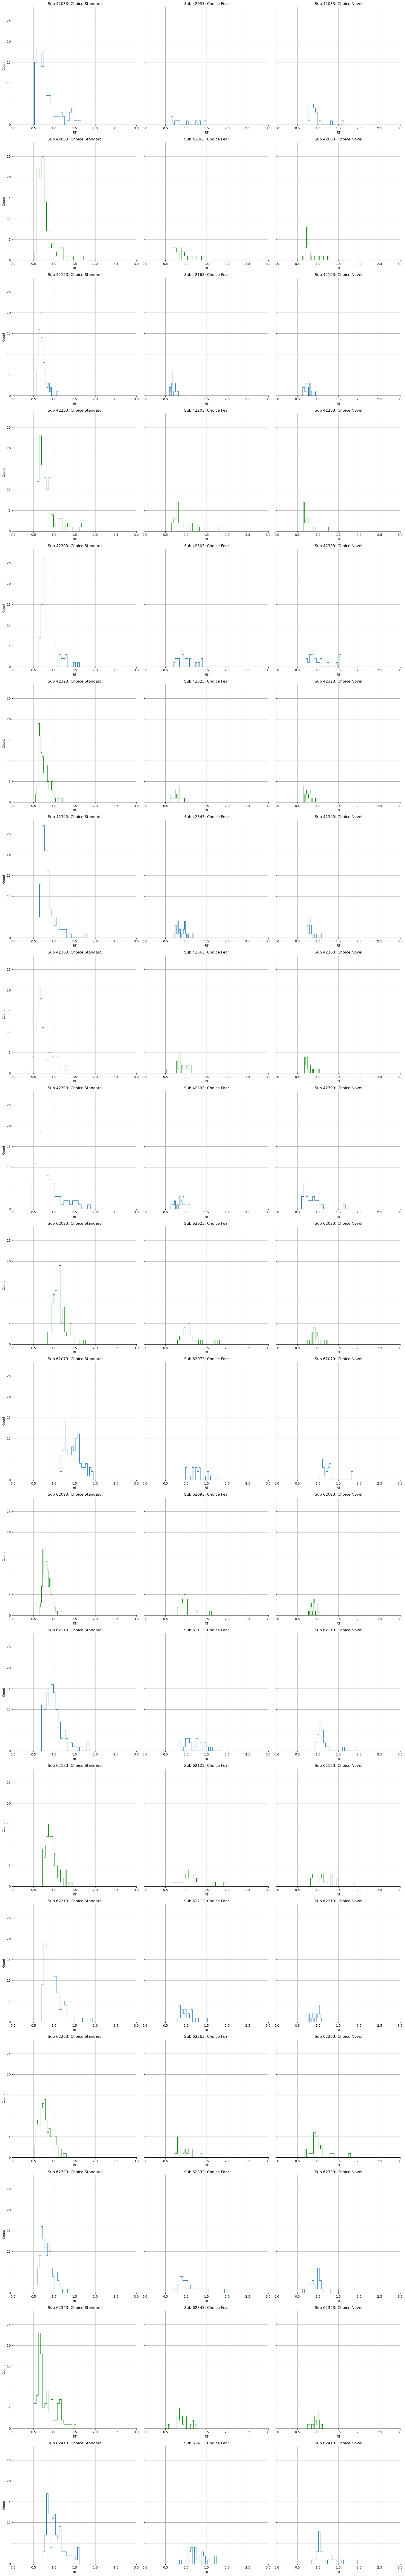

In [16]:
# List of subject IDs
subIDs = [42033, 42063, 42163, 42203, 42303, 42323, 42343, 42363, 42393, 
    62023, 62073, 62093, 62113, 62123, 62213, 62263, 62333, 62343, 
    62413]

n_subs = len(subIDs)
n_responses = 3  # 3 response types

# Create a figure with a grid of subplots, 3 columns for each response, and one row per subject
fig, axes = plt.subplots(n_subs, n_responses, figsize=(18, 6 * n_subs), sharey=True)

# Flatten the axes to make it easier to index
axes = axes.reshape(n_subs, n_responses)


for s in range(n_subs):
    subID = subIDs[s]
    #print(f"Processing subject {subID}")

    # Extract data for the current subject
    subAllData = oddballDataDay2Choice[oddballDataDay2Choice.participant_id == subID]

    # Filter data for each response type
    dataResponse0 = subAllData.loc[subAllData['response'] == 0]
    dataResponse1 = subAllData.loc[subAllData['response'] == 1]
    dataResponse2 = subAllData.loc[subAllData['response'] == 2]

    trace_color = 'green' if s % 2 == 1 else None
    # Alternate row background color
    
    
    # Plot for response == 0
    for i, subj_data in dataResponse0.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 0], color=trace_color)
        axes[s, 0].set_title(f'Sub {subID}: Choice Standard')
        axes[s, 0].set_xlabel('RT')
        axes[s, 0].set_ylabel('Count')
        axes[s, 0].spines['top'].set_visible(False)
        axes[s, 0].spines['right'].set_visible(False)
        axes[s, 0].set_xlim(0, 3)

    # Plot for response == 1
    for i, subj_data in dataResponse1.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 1], color=trace_color)
        axes[s, 1].set_title(f'Sub {subID}: Choice Fear')
        axes[s, 1].set_xlabel('RT')
        axes[s, 1].spines['top'].set_visible(False)
        axes[s, 1].spines['right'].set_visible(False)
        axes[s, 1].set_xlim(0, 3)

    # Plot for response == 2
    for i, subj_data in dataResponse2.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=axes[s, 2], color=trace_color)
        axes[s, 2].set_title(f'Sub {subID}: Choice Novel')
        axes[s, 2].set_xlabel('RT')
        axes[s, 2].spines['top'].set_visible(False)
        axes[s, 2].spines['right'].set_visible(False)
        axes[s, 2].set_xlim(0, 3)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the entire panel figure
plt.savefig(basepath + '/models/race/sept24/numpyro/azTradeOffSubs_RT_dist_plots_combined.jpg')

